In [245]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
import cmocean
from tqdm import tqdm
import pandas as pd
from scipy.stats import circmean, circstd, mode

from datetime import datetime, time, timedelta

import taylorDiagram


import astropy.stats.circstats as astro_circstats

import diurnal_config

from diurnal_utils import *
from fetch_model_helper import *
import dask.dataframe as dd

%run cmip_metrics.py
%run model_by_model_analysis_helper.py

import matplotlib 

font = {'weight' : 'bold',
        'size'   : 13}
label_fontdict = {'weight' : 'bold',
        'size'   : 13}
title_fontdict = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

FLUX_TO_MM_HR = 60*60
MM_HR_TO_MM_DAY = 24.0
MM_HR_TO_MM_YR = 24*365
FLUX_TO_MM_YR = FLUX_TO_MM_HR*MM_HR_TO_MM_YR
FLUX_TO_MM_DAY = FLUX_TO_MM_HR*MM_HR_TO_MM_DAY

HOURS_TO_RADIANS = 2*np.pi/24


In [231]:
rel_data_dir = '/export/data1/cchristo/'
save_figs_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/'
save_figs_dir_paper = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/paper_v1/'
save_figs_dir_update = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/tapio_update_11_17/'
save_figs_dir_quals = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/quals/'
# save_fig_dir_update = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/for_me/'
##### open cmip5
input_data_dir_cm5  = rel_data_dir + 'diurnal_analysis_results/CMIP5_bin_pt2_hr_round_closest_gpm_overlap_2_modes_regridded/grid1/'

#### open cmip6
input_data_dir_cm6  = rel_data_dir + 'diurnal_analysis_results/CMIP6_bin_pt2_hr_round_closest_gpm_overlap_2_modes_regridded/grid1/'




input_data_dir_gpm = rel_data_dir + 'diurnal_analysis_results/GPM_bin_pt2_hr_15_yr_round_final_regridded/grid1/GPM_bin_pt2_hr_15_yr_round_final/'
input_data_dir_gpm_mean_path = rel_data_dir + '/gpm_data/averages/10yr_regridded/grid1/10_yr/grid1_average_10yr.nc'


land_sea_mask = rel_data_dir  + 'land_sea_masks/land_sea_masks_regridded/grid1/grid1_GLDASp4_landmask_1d.nc'

input_data_dir_mean_precip_3hr = rel_data_dir + 'CMIP6_precip/averages/time_averages/period/pr_3hr_regridded/grid1/'
# paths to mean climate fields 

mean_fields_to_rel_path_map_cmip6 = {
#     'rlut': rel_data_dir + 'CMIP6_radiation/averages/time_averages/period/rlut_regridded/grid1/',
#     'rsut': rel_data_dir + 'CMIP6_radiation/averages/time_averages/period/rsut_regridded/grid1/',
    'pr': rel_data_dir + 'CMIP6_precip/averages/time_averages/period/pr_3hr_regridded/grid1/',
#     'clt': rel_data_dir + 'CMIP6_clouds/averages/time_averages/period/clt_regridded/grid1/',
    'clt': rel_data_dir + 'CMIP6_clouds/averages/time_averages/period/clt_30yr_regridded/grid1/',
#     'cltl': rel_data_dir + 'CMIP6_clouds/averages/time_averages/period/cltl_regridded/grid1/',
#     'clth': rel_data_dir + 'CMIP6_clouds/averages/time_averages/period/clth_regridded/grid1/',
}

mean_fields_to_rel_path_map_cmip5 = {
#     'rlut': rel_data_dir + 'CMIP6_radiation/averages/time_averages/period/rlut_regridded/grid1/',
#     'rsut': rel_data_dir + 'CMIP6_radiation/averages/time_averages/period/rsut_regridded/grid1/',
    'pr': rel_data_dir + 'CMIP5_precip/averages/time_averages/period/pr_3hr_regridded/grid1/',
#     'clt': rel_data_dir + 'CMIP5_clouds/averages/time_averages/period/clt_regridded/grid1/',
    'clt': rel_data_dir + 'CMIP5_clouds/averages/time_averages/period/clt_30yr_regridded/grid1/',
#     'cltl': rel_data_dir + 'CMIP6_clouds/averages/time_averages/period/cltl_regridded/grid1/',
#     'clth': rel_data_dir + 'CMIP6_clouds/averages/time_averages/period/clth_regridded/grid1/',
}

# 30yr average
fname_cmip6 = 'grid1_1985-01_2015-01_precip.nc'
fname_cmip5 = 'grid1_1976-01_2006-01_precip.nc'
fname_cmip6_mean = 'grid1_1985-01_2015-01_mean.nc'
fname_cmip5_mean = 'grid1_1976-01_2006-01_mean.nc'

In [232]:
rel_cmip6_path= '/export/data1/cchristo/CMIP6_clouds/clt_3hr_historical/'
rel_cmip5_path = '/export/data1/cchristo/CMIP5_precip/pr_3hr_historical/'

unique_cmip6_models = list(get_unique_models(rel_cmip6_path))
unique_cmip5_models = list(get_unique_models(rel_cmip5_path))

In [233]:

ds_land_sea = xr.open_dataset(land_sea_mask)
df_land_sea = ds_land_sea.to_dataframe().astype(int)
# ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']




## Take mean accross seasons for GPM (circular for phase!)

In [6]:
# df_gpm['mu_season'].values.dtype

In [234]:
%run model_by_model_analysis_helper.py

# open dataset containing gpm means 
df_gpm_mean = xr.open_dataset(input_data_dir_gpm_mean_path).to_dataframe()
df_gpm_mean = df_gpm_mean.rename({'precipitationCal': 'pr_mean'}, axis = 1)

# open and preprocess gpm
df_gpm_seasonal = _open_and_preprocess_gpm(input_data_dir_gpm, ds_land_sea, False)
df_gpm = _open_and_preprocess_gpm(input_data_dir_gpm, ds_land_sea, True)

# get amplitude/mean in mm/hr
df_gpm.loc[:,'ampl_season'] = df_gpm['ampl_season'].apply(lambda x: x*MM_HR_TO_MM_DAY)
df_gpm.loc[:,'mu_season'] = df_gpm['mu_season'].apply(lambda x: x*MM_HR_TO_MM_DAY)

# merge in mean field
df_gpm = pd.merge(df_gpm, df_gpm_mean, how = 'left', left_index = True, right_index = True)
ds_gpm = xr.Dataset.from_dataframe(df_gpm)

df_gpm_seasonal.loc[:,'ampl_season'] = df_gpm_seasonal['ampl_season'].apply(lambda x: x*MM_HR_TO_MM_DAY)
df_gpm_seasonal.loc[:,'mu_season'] = df_gpm_seasonal['mu_season'].apply(lambda x: x*MM_HR_TO_MM_DAY)


In [142]:
# ds_test = xr.open_dataset(input_data_dir_gpm + 'grid1_2000-06_2016-06_precip.nc')
# # np.sqrt(ds_gpm['phase_cov_season'])
# ds_filt = ds_test.where((ds_test['ampl_season'] - 4*np.sqrt(ds_test['ampl_cov_season'])) > 0)

In [59]:
# ds_test['ampl_season'].isel(season = 0).plot(vmax = 0.05)

In [60]:
# ds_test['ampl_cov_season'].isel(season = 0).plot(vmax = 0.00001)

In [143]:
# ds_filt['ampl_season'].isel(season =  0).plot.imshow()

# Load CMIP 5,6 models as a DataFrame

In [235]:
%%time
# # compute yearly mean
df_cm6 = _merge_models_into_df(model_names = unique_cmip6_models, 
                               input_data_dir = input_data_dir_cm6, 
#                                filename = 'grid1_1985-01_2006-01_precip.nc', 
                               filename = fname_cmip6,
#                                filename = 'grid1_1985-01_2015-01_precip.nc',
                               compute_year_mean_bool = True,
                               verbose = False)

df_cm6['cmip_identifier'] = 'CMIP6'

df_cm5 = _merge_models_into_df(model_names = unique_cmip5_models,
                               input_data_dir = input_data_dir_cm5,
#                               filename = 'grid1_1985-01_2006-01_precip.nc', 
                              filename = fname_cmip5,
#                               filename = 'grid1_1976-01_2006-01_precip.nc',
                              compute_year_mean_bool = True,
                              verbose = False)
df_cm5['cmip_identifier'] = 'CMIP5'


# merge cmip5/cmip6
df_models = pd.concat((df_cm5, df_cm6), axis = 0,) #.reset_index('season')

# use only cmip6
# df_models = df_cm6.copy()

# merge land/sea mask
df = pd.merge(df_models, df_land_sea, how = 'left', left_index = True, right_index = True)
# df = df.reset_index('season')
df = df.rename({'GLDAS_mask':'land_sea_mask'}, axis = 1)

CPU times: user 6min 46s, sys: 7.62 s, total: 6min 54s
Wall time: 7min 4s


In [28]:
# df

In [222]:
df_cm6 = _merge_models_into_df(model_names = unique_cmip6_models, 
                               input_data_dir = input_data_dir_cm6, 
#                                filename = 'grid1_1985-01_2006-01_precip.nc', 
#                                filename = 'grid1_2000-01_2015-01_precip.nc',
                               filename = fname_cmip6, 
                               compute_year_mean_bool = False,
                               verbose = False)

df_cm6['cmip_identifier'] = 'CMIP6'

df_cm5 = _merge_models_into_df(model_names = unique_cmip5_models,
                               input_data_dir = input_data_dir_cm5,
#                               filename = 'grid1_1985-01_2006-01_precip.nc', 
                              filename = fname_cmip5,
                              compute_year_mean_bool = False,
                              verbose = False)
df_cm5['cmip_identifier'] = 'CMIP5'


# merge cmip5/cmip6
df_models = pd.concat((df_cm5, df_cm6), axis = 0,).reset_index('season')

# use only cmip6
# df_models = df_cm6.copy()

# merge land/sea mask
df_seasonal = pd.merge(df_models, 
                       df_land_sea, 
                       how = 'left', 
                       left_index = True, 
                       right_index = True)
# df_seasonal = df_seasonal.reset_index('season')
df_seasonal = df_seasonal.rename({'GLDAS_mask':'land_sea_mask'}, axis = 1)

KeyboardInterrupt: 

In [116]:
# plt.savefig(‘test.pdf’, bbox_inches=‘tight’)

# df_seasonal

# Merge mean precip field into dataframe

In [9]:
%run model_by_model_analysis_helper.py
mean_precip_df = _load_all_means(input_data_dir_mean_precip_3hr)
mean_precip_merged = pd.merge(df.reset_index(), 
                              mean_precip_df.reset_index(), 
                              how = 'left', 
                              on = ['lat','lon','model_name'])
mean_precip_merged = mean_precip_merged.set_index(['lat','lon'])

df = mean_precip_merged.copy()


# ## merge mean into seasonal 
# mean_precip_merged = pd.merge(df_seasonal.reset_index(), 
#                               mean_precip_df.reset_index(), 
#                               how = 'left', 
#                               on = ['lat','lon','model_name'])
# mean_precip_merged = mean_precip_merged.set_index(['lat','lon'])

# df_seasonal = mean_precip_merged.copy()


FileNotFoundError: [Errno 2] No such file or directory: b'/export/data1/cchristo/CMIP6_precip/averages/time_averages/period/pr_3hr_regridded/grid1/IPSL-CM6A-LR/grid1_1985-01_2006-01_mean.nc'

In [20]:
phase_circmean(rr['phase_season'].values)

23.829824410327717

In [226]:
phase_circmean(rr_gpm['phase_season'].values)

19.71661745971875

In [227]:
print('mean', phase_circmean(rr['phase_season'].values) - phase_circmean(rr_gpm['phase_season'].values))
print('mode', mode(rr['phase_season'].values.round(1))[0] - mode(rr_gpm['phase_season'].values.round(1))[0])

mean -5.959532688668697
mode [-4.6]


In [213]:
mode(rr['phase_season'].values.round(1))

ModeResult(mode=array([14.1]), count=array([13741]))

In [ ]:
for model_name in df_water['model_name'].unique():
    sns.distplot(df_water[df_water['model_name'] == model_name][field_id].values , 
                 bins = nbins, 
                 ax = ax)



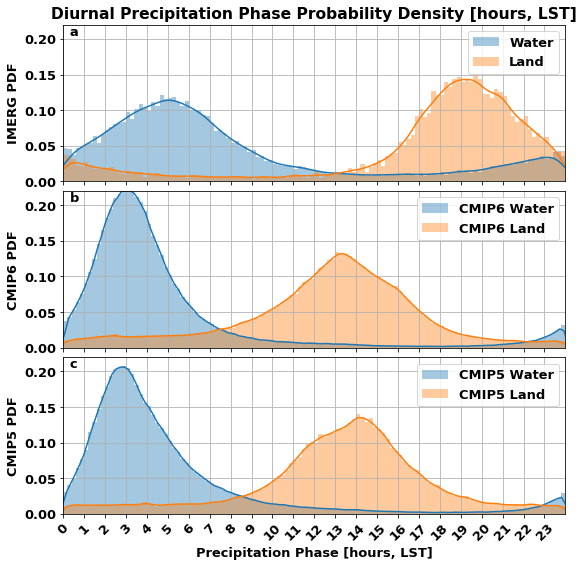

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [237]:
%run model_by_model_analysis_helper.py

fig, ax_hist = plt.subplots(3, 1, sharex = True, figsize = (9,9))

land_sea_histogram(df_gpm, 
                   ax = ax_hist[0],
                   title = 'Diurnal Precipitation Phase Probability Density [hours, LST]',
                   ylabel = 'IMERG PDF',
                   subplot_label = 'a')

land_sea_histogram(df,
                   cmip_identifier= 'CMIP6',
                   ax = ax_hist[1],
                   ylabel = 'CMIP6 PDF',
                   subplot_label = 'b')

land_sea_histogram(df,
                   cmip_identifier = 'CMIP5',
                   ax = ax_hist[2],
                   ylabel = 'CMIP5 PDF',
                   xlabel = 'Precipitation Phase [hours, LST]',
                   subplot_label = 'c')

fig.subplots_adjust(hspace=.06)

# fig.savefig(save_figs_dir_paper + 'yearly_histogram.png', dpi = 300)



# compute error statistics


In [117]:
df_cmip6_seasonal = df_seasonal[df_seasonal['cmip_identifier'] == 'CMIP6']
df_cmip5_seasonal = df_seasonal[df_seasonal['cmip_identifier'] == 'CMIP5']

In [238]:
df_cmip6 = df[df['cmip_identifier'] == 'CMIP6']
df_cmip5 = df[df['cmip_identifier'] == 'CMIP5']




field = 'phase_season'
# season = 'DJF'
# df

df_for_stats = df_cmip6.copy()
# df_for_stats = df_cmip5.copy()
df_for_stats_true = df_gpm.copy()

df_for_stats['ampl_season'] = FLUX_TO_MM_DAY*df_for_stats['ampl_season']
df_for_stats['mu_season'] = FLUX_TO_MM_DAY*df_for_stats['mu_season']
# df_for_stats = df_for_stats[df_for_stats['season'] == season]

df_for_stats_cmip5, df_for_stats_cmip6 = df_cmip5.copy(), df_cmip6.copy()
df_for_stats_cmip5['ampl_season'] = FLUX_TO_MM_DAY*df_for_stats_cmip5['ampl_season']
df_for_stats_cmip6['ampl_season'] = FLUX_TO_MM_DAY*df_for_stats_cmip6['ampl_season']

df_for_stats_land = df_for_stats[df_for_stats['land_sea_mask'] == 1]
df_for_stats_water = df_for_stats[df_for_stats['land_sea_mask'] == 0]

df_for_stats_true_land = df_for_stats_true[df_for_stats_true['land_sea_mask'] == 1]
df_for_stats_true_water = df_for_stats_true[df_for_stats_true['land_sea_mask'] == 0]



In [225]:
# df_for_stats_true = df_gpm[df_gpm['season'] == season]

# # compute precip weights
# df_for_stats_true['precip_weights'] = df_for_stats_true['mu_season']/df_for_stats_true['mu_season'].sum()

# # merge gpm precip weights into model df 
# df_for_stats = pd.merge(df_for_stats, 
#                         df_for_stats_true['precip_weights'], 
#                         how = 'left', 
#                         left_index = True, 
#                         right_index = True)


df_lat_lon_mean = df_for_stats.groupby(['lat','lon']).mean()
# df_lat_lon_mode_phase = df_for_stats.round(1).groupby(['lat','lon'])['phase_season'].agg(mode_apply)
# df_lat_lon_mode_ampl = df_for_stats.round(4).groupby(['lat','lon'])['ampl_season'].agg(mode_apply)

# df_lat_lon_err = df_lat_lon_mean - df_for_stats_true
# df_lat_lon_err = circdiff(df_lat_lon_mean, df_for_stats_true)
# cmips_err_ds = xr.Dataset.from_dataframe(df_lat_lon_err)
# cmips_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean)



# ampl_weighted_mean_df = df_for_stats[['ampl_season', 'precip_weights', 'model_name']].groupby('model_name').apply(ampl_weighted_mean_func)

# ampl_weighted_mean_df = df_for_stats[['ampl_season', 'model_name']].groupby('model_name').apply(ampl_weighted_mean_func)

df_lat_lon_mean_cmip5 = df_for_stats_cmip5.groupby(['lat','lon']).mean()
cmip5_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean_cmip5)


df_lat_lon_mean_cmip6 = df_for_stats_cmip6.groupby(['lat','lon']).mean()
cmip6_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean_cmip6)


df_lat_lon_err_cm6 = circdiff(df_lat_lon_mean_cmip6, df_for_stats_true)
cmip6_err_ds = xr.Dataset.from_dataframe(df_lat_lon_err_cm6)
# cmips6_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean)

df_lat_lon_err_cm5 = circdiff(df_lat_lon_mean_cmip5, df_for_stats_true)
cmip5_err_ds = xr.Dataset.from_dataframe(df_lat_lon_err_cm5)
# cmips_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean)




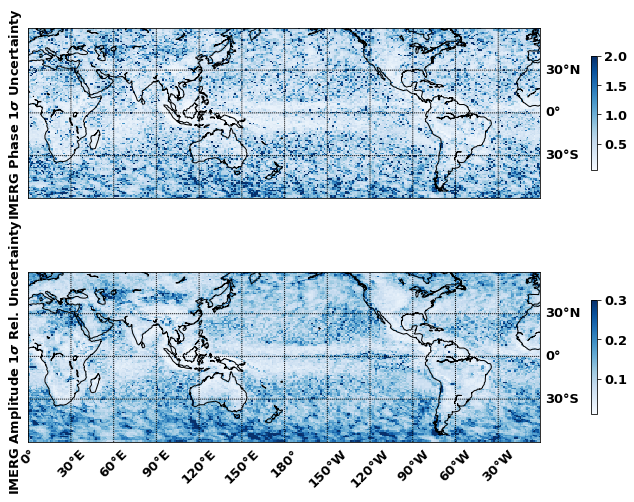

In [208]:
# cmips_mean_ds['phase_cov_season'].to_dataset().apply(np.sqrt)['phase_cov_season']

# make_single_plot(ds_gpm['phase_cov_season'].to_dataset().apply(np.sqrt)['phase_cov_season'] ,
#                  title = 'Mean Precip',
#                  vmin = 0, vmax = 10, 
#                  cmap  =plt.get_cmap('gist_ncar'))

# make_single_plot(ds_gpm['ampl_cov_season'].to_dataset().apply(np.sqrt)['ampl_cov_season'] ,
#                  title = 'Mean Precip',
#                  vmin = 0, vmax = 10, 
#                  cmap  =plt.get_cmap('gist_ncar'))


fig, ax_hist = plt.subplots(2, 1, sharex = True, figsize = (9,7))

make_single_plot(ds_gpm['phase_cov_season'].to_dataset().apply(np.sqrt)['phase_cov_season'], 
                 ax = ax_hist[0],
                 title = None,
                 fig = fig,
                 xticks_bool = False,
                 ylabel = r'IMERG Phase $1 \sigma$ Uncertainty ',
                 cmap = plt.get_cmap('Blues'), vmax = 2)
# plt.savefig(save_figs_dir + 'GPM/' + 'mu_mean_spatial.png', dpi = 300)
ampl_rel_uncer = (MM_HR_TO_MM_DAY*ds_gpm['ampl_cov_season'].to_dataset().apply(np.sqrt)['ampl_cov_season'])/ds_gpm['ampl_season']
make_single_plot(ampl_rel_uncer,
                 ax = ax_hist[1],
                 title = None,
                 fig = fig,
                 vmax = 0.3,
                 ylabel = r'IMERG Amplitude $1 \sigma$ Rel. Uncertainty',
                cmap = plt.get_cmap('Blues'))
fig.subplots_adjust(hspace=.001)
fig.tight_layout()

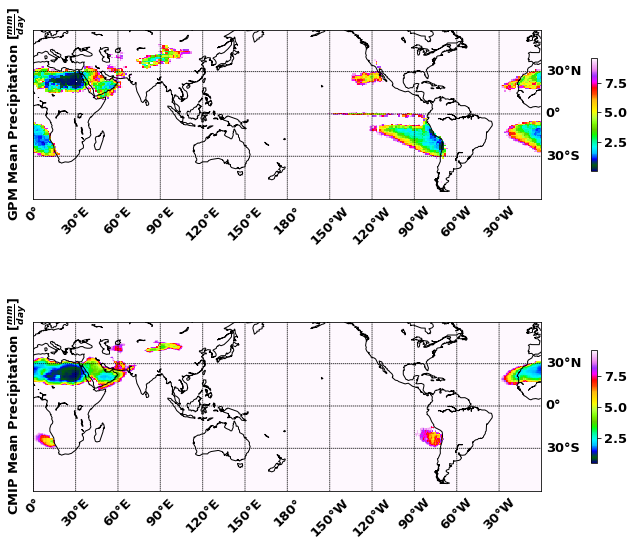

In [167]:


fig, ax_hist = plt.subplots(2, 1, sharex = True, figsize = (9,9))


# make_single_plot(ds_gpm['phase_season'], 
#                  title = r'Mean Diurnal Precipitation Phase [hours]',
#                  ax = ax_hist[0],
#                  fig = fig,
#                  ylabel = 'IMERG', 
#                  xticks_bool = False,
#                  cmap = plt.get_cmap('twilight_shifted'),
#                  vmin = 0, vmax = 24)





make_single_plot(ds_gpm['mu_season']*24, 
                 ax = ax_hist[0],
                 title = None,
                 fig = fig,
                 ylabel = r'GPM Mean Precipitation [$\frac{mm}{day}$]',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*24)
# plt.savefig(save_figs_dir + 'GPM/' + 'mu_mean_spatial.png', dpi = 300)
make_single_plot(cmips_mean_ds['mu_season'] *24, 
                 ax = ax_hist[1],
                 title = None,
                 fig = fig,
                 ylabel = r'CMIP Mean Precipitation [$\frac{mm}{day}$]',
                cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*24)
# plt.savefig(save_figs_dir + 'tapio_update_8_26/' + 'mu_mean_spatial.png', dpi = 300)

# make_single_plot(cmips_mean_ds['mu_season'].where(cmips_mean_ds['mu_season'] > 0.04), 
#                  title = r'CMIP Mean Precipitation [$\frac{mm}{yr}$]',
#                   cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)

In [112]:
ds_gpm['mu_season'].mean() - cmips_mean_ds['mu_season'].mean()

<xarray.DataArray 'mu_season' ()>
array(0.00112189)

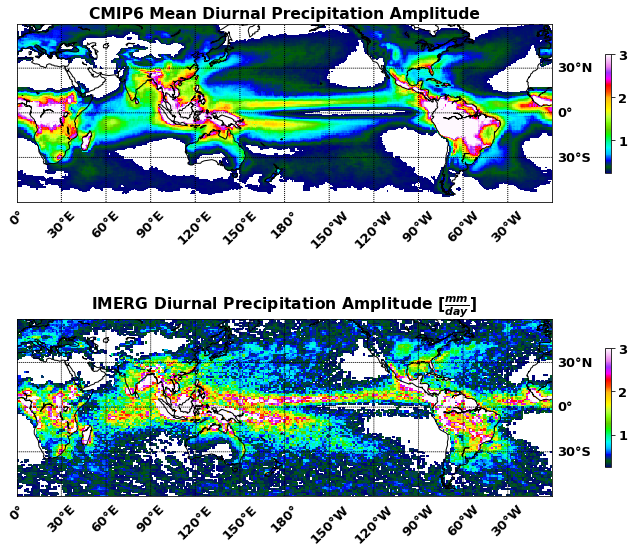

In [416]:
fig, ax_hist = plt.subplots(2, 1, sharex = True, figsize = (9,9))

filter_ampl = 0.25
make_single_plot((cmips_mean_ds['ampl_season']*MM_HR_TO_MM_DAY).where((cmips_mean_ds['ampl_season']*MM_HR_TO_MM_DAY)> filter_ampl), 
                 fig = fig,
                 ax = ax_hist[0],
                 title = r'CMIP6 Mean Diurnal Precipitation Amplitude',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 3)

make_single_plot((ds_gpm['ampl_season']*MM_HR_TO_MM_DAY).where((ds_gpm['ampl_season']*MM_HR_TO_MM_DAY)> filter_ampl),
                 fig = fig,
                 ax = ax_hist[1],
                 title = r'IMERG Diurnal Precipitation Amplitude [$\frac{mm}{day}$]',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 3)


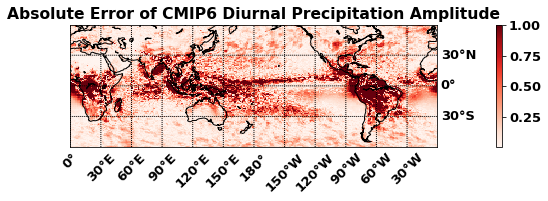

In [45]:
make_single_plot(cmips_err_ds['ampl_season'], 
                 title = r'Absolute Error of CMIP6 Diurnal Precipitation Amplitude',
                 cmap = plt.get_cmap('Reds'), vmax = 1)
# plt.savefig(save_figs_dir + 'compare_models/' + 'ampl_abs_error_spatial.png', dpi = 300)

In [191]:
# plt.get_cmap('hsv').N
# bounds = np.arange(0,25)
# bounds
# plt.cm

In [195]:
plt.Bound

<module 'matplotlib.cm' from '/home/cchristo/.conda/envs/diurnal_research/lib/python3.6/site-packages/matplotlib/cm.py'>

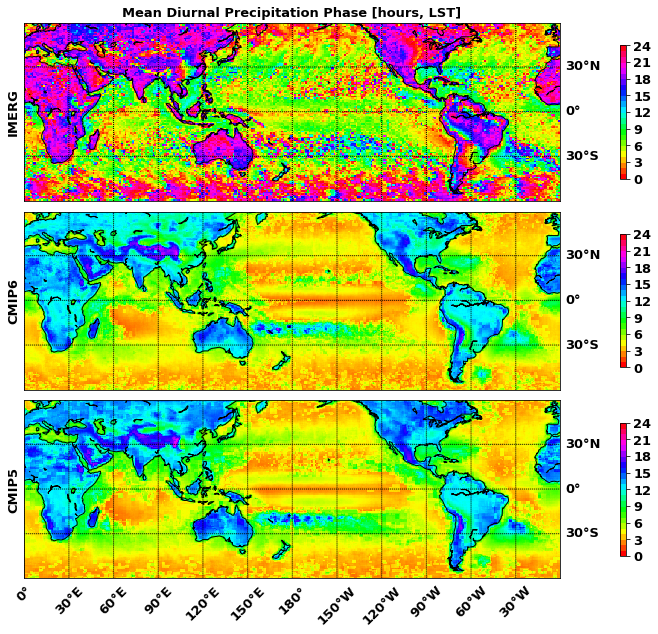

In [226]:
%run diurnal_utils.py

cmap =  plt.get_cmap('hsv')
bounds = np.arange(0,25)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig, ax_hist = plt.subplots(3, 1, sharex = True, figsize = (10,9))



make_single_plot(ds_gpm['phase_season'], 
                 title = r'Mean Diurnal Precipitation Phase [hours, LST]',
                 ax = ax_hist[0],
                 fig = fig,
                 ylabel = 'IMERG', 
                 xticks_bool = False,
                 cmap = cmap,
                 cbar = cbar,
                 vmin = 0, vmax = 24)

make_single_plot(cmip6_mean_ds['phase_season'], 
#                  title = r'Mean CMIP6 Diurnal Precipitation Phase',
                 title = None,
                 ax = ax_hist[1],
                 fig = fig,
                 ylabel = 'CMIP6',
                 xticks_bool = False,
                 cmap = cmap,
                 cbar = cbar,
                 vmin = 0, vmax = 24)

make_single_plot(cmip5_mean_ds['phase_season'], 
#                  title = r'Mean Diurnal Precipitation Phase',
                 title = None, 
                 ax = ax_hist[2],
                 fig = fig,
                 ylabel = 'CMIP5',
                 cmap = cmap,
                 cbar = cbar,
                 vmin = 0, vmax = 24)




fig.subplots_adjust(hspace=.06)
# fig.savefig(save_figs_dir_paper + 'phase_mean_spatial_yearly.png', dpi = 300)



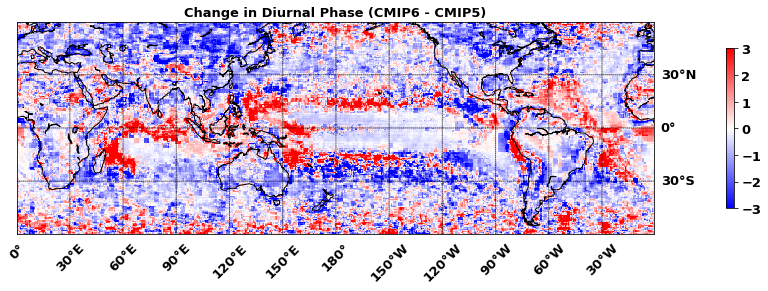

In [39]:

make_single_plot(cmip6_mean_ds['phase_season'] - cmip5_mean_ds['phase_season'], 
#                  title = r'Mean Diurnal Precipitation Phase',
                 title = 'Change in Diurnal Phase (CMIP6 - CMIP5)', 
#                  ax = ax_hist[2],
#                  fig = fig,
#                  ylabel = 'CMIP6 - CMIP5',
                 cmap = plt.get_cmap('bwr'),
                 vmin = -3, vmax = 3)
plt.savefig(save_figs_dir_paper + 'change_in_diurnal_phase.png', dpi = 300)

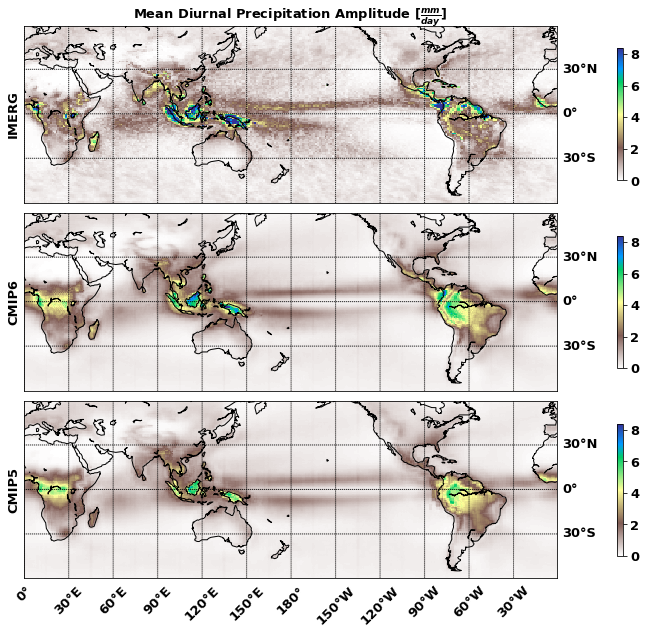

In [254]:
%run diurnal_utils.py
fig, ax_hist = plt.subplots(3, 1, sharex = True, figsize = (10,9))

cmap = plt.get_cmap('terrain_r')
# cmap = cmocean.cm.rain
# vmax =  0.4*MM_HR_TO_MM_DAY
vmax = 0.35*MM_HR_TO_MM_DAY
make_single_plot(ds_gpm['ampl_season'], 
                 title = r'Mean Diurnal Precipitation Amplitude [$\frac{mm}{day}$]',
                 ax = ax_hist[0],
                 fig = fig,
                 ylabel = 'IMERG', 
                 xticks_bool = False,
                 cmap = cmap,
                 vmin = 0, vmax = vmax)

make_single_plot(cmip6_mean_ds['ampl_season'], 
#                  title = r'Mean CMIP6 Diurnal Precipitation Phase',
                 title = None,
                 ax = ax_hist[1],
                 fig = fig,
                 ylabel = 'CMIP6',
                 xticks_bool = False,
                 cmap = cmap,
                 vmin = 0, vmax = vmax)

make_single_plot(cmip5_mean_ds['ampl_season'], 
#                  title = r'Mean Diurnal Precipitation Phase',
                 title = None, 
                 ax = ax_hist[2],
                 fig = fig,
                 ylabel = 'CMIP5',
                 cmap = cmap,
                 vmin = 0, vmax = vmax)

fig.subplots_adjust(hspace=.06)

# fig.savefig(save_figs_dir_paper + 'ampl_mean_spatial_yearly.png', dpi = 300)

In [315]:
# cmips_mean_ds
cmips_mean_ds['phase_cov_season'].to_dataset().apply(np.sqrt)

<xarray.Dataset>
Dimensions:           (lat: 240, lon: 720)
Coordinates:
  * lat               (lat) float64 -60.0 -59.5 -59.0 -58.5 ... 58.5 59.0 59.5
  * lon               (lon) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
Data variables:
    phase_cov_season  (lat, lon) float64 0.2672 0.2721 0.2633 ... 0.355 0.3265

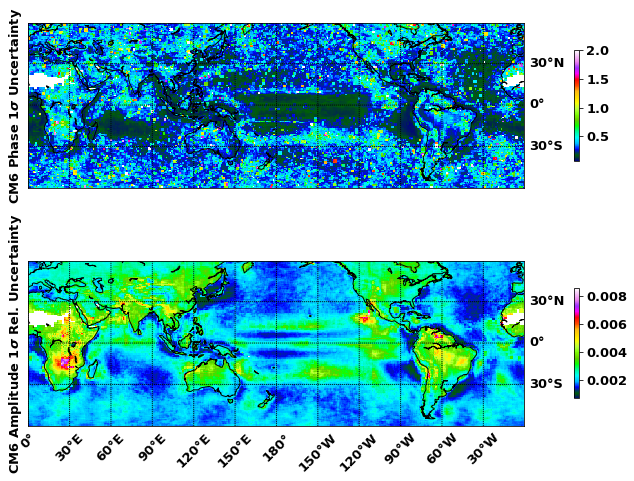

In [171]:
fig, ax_hist = plt.subplots(2, 1, sharex = True, figsize = (9,7))

make_single_plot(cmips_mean_ds['phase_cov_season'].to_dataset().apply(np.sqrt)['phase_cov_season'], 
                 ax = ax_hist[0],
                 title = None,
                 fig = fig,
                 xticks_bool = False,
                 ylabel = r'CM6 Phase $1 \sigma$ Uncertainty ',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 2)
# plt.savefig(save_figs_dir + 'GPM/' + 'mu_mean_spatial.png', dpi = 300)
ampl_rel_uncer = (FLUX_TO_MM_HR*cmips_mean_ds['ampl_cov_season'].to_dataset().apply(np.sqrt)['ampl_cov_season'])/cmips_mean_ds['ampl_season']
make_single_plot(ampl_rel_uncer,
                 ax = ax_hist[1],
                 title = None,
                 fig = fig,
                 ylabel = r'CM6 Amplitude $1 \sigma$ Rel. Uncertainty',
                cmap = plt.get_cmap('gist_ncar'))
fig.subplots_adjust(hspace=.001)
fig.tight_layout()
# plt.savefig(save_fig_dir_update + 'fit_error.png', dpi = 300)

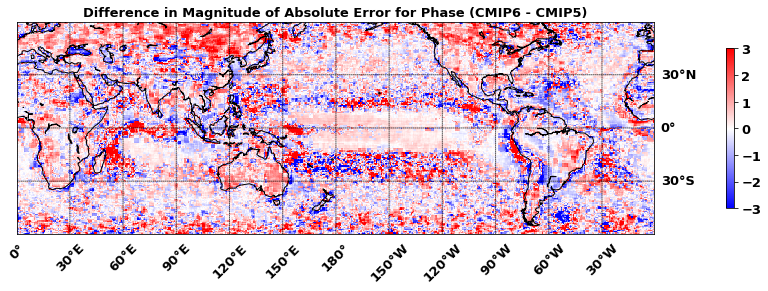

In [58]:
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('gist_ncar'), vmin = -5, vmax = 5)
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('seismic_r'))
# fig, ax_hist = plt.subplots(3, 1, sharex = True, figsize = (10,9))

# make_single_plot(cmip6_err_ds['phase_season'], 
#                  title = r'Absolute Error of CMIP6 Diurnal Precipitation Phase',
#                  ax = ax_hist[0],
#                  fig = fig,
#                  cmap = plt.get_cmap('Reds'), vmax = 10)

# make_single_plot(cmip5_err_ds['phase_season'], 
#                  title = r'Absolute Error of CMIP5 Diurnal Precipitation Phase',
#                  ax = ax_hist[1],
#                  fig = fig,
#                  cmap = plt.get_cmap('Reds'), vmax = 10)

# make_single_plot(cmip6_err_ds['ampl_season']/cmip6_mean_ds['ampl_season'] - cmip5_err_ds['ampl_season']/cmip5_mean_ds['ampl_season'], 
#                  title = r'Change in Relative Error of CMIP6 Diurnal Precipitation Amplitude',
#                  ax = ax_hist[0],
#                  fig = fig,
#                  cmap = plt.get_cmap('bwr'), vmin = -1, vmax = 1)

make_single_plot(cmip6_err_ds['phase_season'] - cmip5_err_ds['phase_season'], 
                 title = r'Difference in Magnitude of Absolute Error for Phase (CMIP6 - CMIP5)',
#                  ax = ax_hist[2],
#                  fig = fig,
                 cmap = plt.get_cmap('bwr'), vmin = -3, vmax = 3)
plt.savefig(save_figs_dir_paper + 'diff_abs_phase_error.png', dpi = 100)

In [59]:
# make_single_plot(cmip6_err_ds['phase_season'], 
#                  title = r'Absolute Error diff Diurnal Precipitation Phase',
#                  cmap = plt.get_cmap('bwr'), vmin = -3, vmax = 3)

# Taylor Plots

In [95]:
# gpm_std = df_gpm[field].std()
gpm_std =  circstd(df_gpm['phase_season'], low = 0.0, high = 24.0)
gpm_land_std = circstd(df_gpm_land['phase_season'], low = 0.0, high = 24.0)
gpm_water_std = circstd(df_gpm_water['phase_season'],low = 0.0, high = 24.0)

# # calculate obs ampl
# obs_water_std = hour_circstd(obs_water_df['phase_season'])
# obs_land_std = hour_circstd(obs_land_df['phase_season'])


In [198]:
mean_fields_to_rel_path_map_cmip6

{'rlut': '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rlut_regridded/grid1/',
 'rsut': '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rsut_regridded/grid1/',
 'pr': '/export/data1/cchristo/CMIP6_precip/averages/time_averages/period/pr_regridded/grid1/',
 'clt': '/export/data1/cchristo/CMIP6_clouds/averages/time_averages/period/clt_regridded/grid1/',
 'cltl': '/export/data1/cchristo/CMIP6_clouds/averages/time_averages/period/cltl_regridded/grid1/',
 'clth': '/export/data1/cchristo/CMIP6_clouds/averages/time_averages/period/clth_regridded/grid1/'}

In [249]:
# input_data_dir_rlut
# mean_fields_to_rel_path_map_cmip6

{'rlut': '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rlut_regridded/grid1/',
 'rsut': '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rsut_regridded/grid1/',
 'pr': '/export/data1/cchristo/CMIP6_precip/averages/time_averages/period/pr_regridded/grid1/',
 'clt': '/export/data1/cchristo/CMIP6_clouds/averages/time_averages/period/clt_regridded/grid1/'}

In [ ]:
# os.listdir(input_data_dir_rlut)
%run model_by_model_analysis_helper.py

In [12]:


%run model_by_model_analysis_helper.py

# tropics
# min_lat, max_lat = -30, 30
# field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt'],
#                        mean_fields_to_rel_path_map = mean_fields_to_rel_path_map_cmip6,
#                        filter_by_lat = True,
#                        **{'min_lat': min_lat,
#                        'max_lat': max_lat})


# # tropics water
# min_lat, max_lat = -30, 30
# field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt', 'cltl', 'clth'],
#                       mean_fields_to_rel_path_map = mean_fields_to_rel_path_map_cmip6,
#                       file_name = 'grid1_1985-01_2006-01_mean.nc',
#                       filter_lat = True,
#                       landsea_mask_df = df_land_sea,
#                       landsea_bool = 0,
#                        **{'min_lat': min_lat,
#                           'max_lat': max_lat,
#                           'absolute_value': False})
# subtropics
# min_lat, max_lat = 30, 60
min_lat, max_lat = -60, 60

field_means_df_cmip6 = _get_mean_fields(field_names = ['clt',], #['rlut','rsut', 'pr', 'clt'],
                       mean_fields_to_rel_path_map = mean_fields_to_rel_path_map_cmip6,
#                        file_name = 'grid1_2000-01_2015-01_mean.nc',
#                        file_name = 'grid1_1985-01_2015-01_mean.nc',
                       file_name = fname_cmip6_mean, 
                       landsea_mask_df = df_land_sea,
                       landsea_bool = 0,
                       filter_lat = True,
                       **{'min_lat': min_lat,
                          'max_lat': max_lat,
                          'absolute_value': False})

field_means_df_cmip5 = _get_mean_fields(field_names = ['clt',], #['rlut','rsut', 'pr', 'clt'],
                       mean_fields_to_rel_path_map = mean_fields_to_rel_path_map_cmip5,
#                        file_name = 'grid1_1991-01_2006-01_mean.nc',
#                        file_name = 'grid1_1976-01_2006-01_mean.nc',
                       file_name = fname_cmip5_mean,
                       landsea_mask_df = df_land_sea,
                       landsea_bool = 0,
                       filter_lat = True,
                       **{'min_lat': min_lat,
                          'max_lat': max_lat,
                          'absolute_value': False})


# rr = _get_mean_field(field_name = 'pr',
#                       data_dir = mean_fields_to_rel_path_map['pr'],
#                       file_name = 'grid1_1985-01_2006-01_mean.nc',
#                       filter_lat = True,
#                       landsea_mask_df = df_land_sea,
#                       var_mask_df = pr_mask_dict,
#                       landsea_bool = 0,
#                        **{'min_lat': min_lat,
#                           'max_lat': max_lat,
#                           'absolute_value': False})




# stats_kwargs = {'ecs_dict': cmip6_ecs, 'tcr_dict': cmip6_tcr, 
#      'rlut_dict': rlut_dict, 'rsut_dict': rsut_dict, 
#      'pr_dict': pr_dict, 'clt_dict': clt_dict}

In [75]:
# field_means_df_cmip6
# mean_fields_to_rel_path_map_cmip6
print('Done')

Done


In [76]:
%run model_by_model_analysis_helper.py




In [138]:
cmip_sens = cmip6_sensitivities.reset_index().rename({'index':'model_name'}, axis = 1)
# cmip_sens = cmip5_sensitivities.reset_index().rename({'index':'model_name'}, axis = 1)
# cmip_means = field_means_df.reset_index().rename({'index':'model_name'}, axis = 1)
# cmip_means = field_means_df_cmip5.reset_index().rename({'index':'model_name'}, axis = 1)
merged_df = pd.merge(df_for_stats_water.reset_index(), cmip_sens,
                    how = 'left',
                    on = 'model_name')
# merged_df = pd.merge(df_for_stats_water.reset_index(), cmip_means,
#                     how = 'left',
#                     on = 'model_name')

In [398]:
# compute stats for all points
# df_for_stats[df_for_stats['ampl_season']> 0.001
%run model_by_model_analysis_helper.py
# model_error_stats_df= compute_stats(df_for_stats,
#                  df_for_stats_true,
#                  field = 'phase_season',
#                  agg_method = 'mode',
#                  error_stats = True,
#                  additional_stats = True,)                

# model_error_stats_df_land = compute_stats(df_for_stats_land,
#                  df_for_stats_true_land,
#                  field = 'phase_season',
#                  agg_method = 'mode',
#                  additional_stats = True,)


# ### compute stats for land/water
# model_error_stats_df_water = compute_stats(df_for_stats_water,
#                  df_for_stats_true_water,
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True,)


# model_error_stats_df_water = compute_stats(filter_by_lat(df_for_stats_water, min_lat, max_lat),
#                  filter_by_lat(df_for_stats_true_water, min_lat, max_lat),
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  **stats_kwargs)

# model_error_stats_df_land = compute_stats(df_for_stats_land,
#                  df_for_stats_true_land,
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  **stats_kwargs)

####### compute stats for given latitude range
# min_lat, max_lat = -60, 60
# # # # min_lat, max_lat = 30, 60
# # # # min_lat, max_lat = 0, 60

# # # # min_lat, max_lat = 30, 60
# absolute_values = False

# # # print(min_lat, max_lat)
# # df_for_stats_filt = filter_by_lat(df_for_stats, min_lat, max_lat, absolute_value=False)
# # df_for_stats_true_filt = filter_by_lat(df_for_stats_true, min_lat, max_lat, absolute_value=False)


# df_for_stats_filt_land = filter_by_lat(df_for_stats_land, min_lat, max_lat, absolute_value=absolute_values)
# df_for_stats_true_filt_land = filter_by_lat(df_for_stats_true_land, min_lat, max_lat, absolute_value=absolute_values)


# df_for_stats_filt_water = filter_by_lat(df_for_stats_water, min_lat, max_lat, absolute_value=absolute_values)
# df_for_stats_true_filt_water = filter_by_lat(df_for_stats_true_water, min_lat, max_lat, absolute_value=absolute_values)



# # model_error_stats_df = compute_stats(df_for_stats_filt,
# #                  df_for_stats_true_filt,
# #                  agg_method = 'mean',
# #                  field = 'phase_season',
# #                  additional_stats = True, 
# #                  **stats_kwargs)
                

    
    

# model_error_stats_df_water = compute_stats(df_for_stats_filt_water,
#                  df_for_stats_true_filt_water,
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  agg_method = 'mode',)

# model_error_stats_df_land = compute_stats(df_for_stats_filt_land,
#                  df_for_stats_true_filt_land,
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  agg_method = 'mode',)

In [13]:
# # tropics water
%run model_by_model_analysis_helper.py

min_lat, max_lat = -60, 60

pr_mask_dict_cmip6 = {'data_dir': mean_fields_to_rel_path_map_cmip6['pr'],
               'field_to_mask': 'pr',
               'field_threshold' : 5,
               'operator': 'gt',
               'file_name': fname_cmip6_mean,
               'unit_conversion': FLUX_TO_MM_DAY}

var_mask_df_cmip6 = _create_mask_for_all_models(
                model_list = os.listdir(mean_fields_to_rel_path_map_cmip6['pr']),
                **pr_mask_dict_cmip6)
# ['rlut','rsut', 'pr', 'clt', 'clth','cltl']
field_means_df_cmip6 = _get_mean_fields(field_names = ['pr', 'clt'],
                      mean_fields_to_rel_path_map = mean_fields_to_rel_path_map_cmip6,
                      file_name = fname_cmip6_mean,
#                       var_mask_df = pr_mask_dict,
                      filter_lat = True,
                      landsea_mask_df = df_land_sea,
                      landsea_bool = 0,
                       **{'min_lat': min_lat,
                          'max_lat': max_lat,
                          'absolute_value': False})

pr_mask_dict_cmip5 = {'data_dir': mean_fields_to_rel_path_map_cmip5['pr'],
               'field_to_mask': 'pr',
               'field_threshold' : 5,
               'operator': 'gt',
               'file_name': fname_cmip5_mean,
               'unit_conversion': FLUX_TO_MM_DAY}

var_mask_df_cmip5 = _create_mask_for_all_models(
                model_list = os.listdir(mean_fields_to_rel_path_map_cmip5['pr']),
                **pr_mask_dict_cmip5)


field_means_df_cmip5 = _get_mean_fields(field_names = ['pr', 'clt'],
                      mean_fields_to_rel_path_map = mean_fields_to_rel_path_map_cmip5,
                      file_name = fname_cmip5_mean,
#                       var_mask_df = pr_mask_dict,
                      filter_lat = True,
                      landsea_mask_df = df_land_sea,
                      landsea_bool = 0,
                       **{'min_lat': min_lat,
                          'max_lat': max_lat,
                          'absolute_value': False})

FileNotFoundError: [Errno 2] No such file or directory: b'/export/data1/cchristo/CMIP6_precip/averages/time_averages/period/pr_3hr_regridded/grid1/IPSL-CM6A-LR/grid1_1985-01_2015-01_mean.nc'

In [62]:
# var_mask_df_cmip5[var_mask_df_cmip5['model_name'] == 'GFDL-ESM2G']
# field_means_df_cmip5['pr']*FLUX_TO_MM_DAY

## Filter based on 3hr preciptiation means

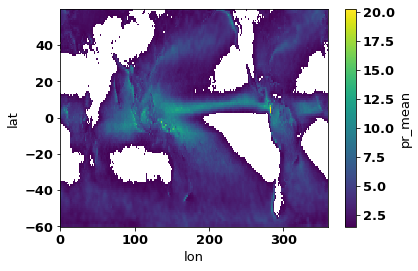

In [93]:
pr_mean_gpm_ds = df_gpm['pr_mean'].apply(lambda x: x*MM_HR_TO_MM_DAY)
pr_mean_gpm_ds = xr.Dataset.from_dataframe(pd.DataFrame(pr_mean_gpm_ds))

pr_mean_gpm_ds['pr_mean'].where(pr_mean_gpm_ds['pr_mean'] > 1.5).plot.imshow()

In [80]:
var_mask_df = df_cmip6[['model_name','pr_mean']].copy()
var_mask_df.loc[:,'pr_mean'] = var_mask_df['pr_mean'].apply(lambda x: x*FLUX_TO_MM_DAY)

## Filter based on monthly-mean precip data

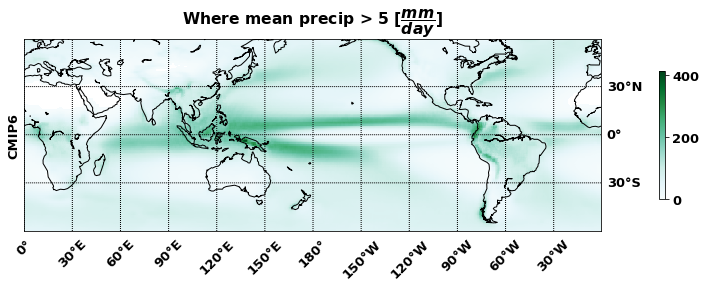

In [65]:
# field_means_df
fig = plt.figure(figsize = (10,8))
precip_where = (cmips_mean_ds['mu_season']*24).where(cmips_mean_ds['mu_season']*24 > 5)
make_single_plot(precip_where, 
#                  title = r'Correlation between Diurnal Precipitation Phase & Clt',
                 title = 'Where mean precip > 5 [$\dfrac{mm}{day}$]',
                 ax = plt.gca(),
                 fig = fig,
                 ylabel = 'CMIP6', 
                 xticks_bool = True,
                 cmap = plt.get_cmap('BuGn'),
                 vmin = 0,)
# plt.savefig(save_fig_dir_update + 'mean_precip_lt_5pt0_map.png', dpi = 300)

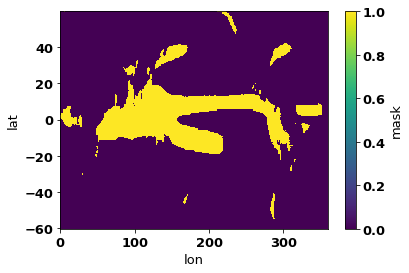

In [400]:
precip_mask = (precip_where > 0)
precip_mask.name = 'mask'
precip_mask_df = precip_mask.to_dataframe()
precip_mask.plot.imshow()

In [268]:

### select season
# season_ii = 'DJF'
# df_for_analysis = model_error_stats_df_water
# df_for_analysis = df_for_analysis.reset_index('season')
# df_for_analysis = df_for_analysis[df_for_analysis['season'] == season_ii]


### yearly mean
df_for_analysis = model_error_stats_df_water

merge_sensitivities = pd.merge(df_for_analysis, cmip5_sensitivities, 
         how = 'left',
         left_index = True, 
         right_index = True)
all_stats_df = pd.merge(merge_sensitivities, field_means_df,
         how = 'left',
         left_index = True, 
         right_index = True)

NameError: name 'model_error_stats_df_water' is not defined

# Analysis Used for Paper

In [28]:
%%time
%run model_by_model_analysis_helper.py


# cmip6_stats_water, cmip6_stats_land = full_analysis(df_cmip6,
#                     df_gpm,
#                     cmip6_sensitivities,
#                     field_means_df, 
# #                     var_mask_df = var_mask_df,
#                     min_lat = -60, 
#                     max_lat = 60)
########################## for paper 
### NOTE: when using var_mask_df -> turn off lat filtering and error stats

# # analysis with error stats (CMIP6)
# model_error_stats_df_water, model_error_stats_df_land = full_analysis(df_cmip6,
#                     df_gpm,
#                     cmip6_sensitivities,
#                     field_means_df_cmip6, 
# #                     var_mask_df = var_mask_df_cmip6,
#                     agg_method = 'mode',
#                     error_stats = True,)
# #                     min_lat = -60, 
# #                     max_lat = 60)

model_error_stats_df_water_mean, model_error_stats_df_land_mean = full_analysis(df_cmip6,
                    df_gpm,
                    cmip6_sensitivities,
#                     field_means_df_cmip6, 
#                     var_mask_df = var_mask_df_cmip6,
                    agg_method = 'mean',
                    error_stats = True,)
#                     min_lat = -60, 
#                     max_lat = 60, 
#                     absolute_value = False)


# # # # # analysis with error stats (CMIP5)
# model_error_stats_df_water_cmip5, model_error_stats_df_land_cmip5 = full_analysis(df_cmip5,
#                     df_gpm,
#                     cmip5_sensitivities,
#                     field_means_df_cmip5,  
# #                     var_mask_df = var_mask_df_cmip5,
#                     agg_method = 'mode',
#                     error_stats = True,)
# #                     min_lat = -60, 
# #                     max_lat = 60)


# model_error_stats_df_water_cmip5_mean, model_error_stats_df_land_cmip5_mean = full_analysis(df_cmip5,
#                     df_gpm, 
#                     cmip5_sensitivities,
# #                     field_means_df_cmip5,   
# #                     var_mask_df = var_mask_df_cmip5,
#                     agg_method = 'mean',
#                     error_stats = True,)
# #                     min_lat = -60, 
# #                     max_lat = 60,
# #                     absolute_value = False)
                                                                                
########################## end for paper 
# Seasonal analysis

# cmip6_stats_water_seas, _ = full_analysis(df_cmip6_seasonal,
#                                             df_gpm_seasonal,
#                                             cmip6_sensitivities,
# #                                             field_means_df,
#                                             agg_method = 'mean',
#                                             min_lat = -60,
#                                             max_lat = 0)
# cmip6_stats_water_summer = cmip6_stats_water_summer[cmip6_stats_water_summer['season'] == 'JJA']


# cmip5_stats_water_seas, cmip5_stats_land_seas = full_analysis(df_cmip5_seasonal,
#                                             df_gpm_seasonal,
#                                             cmip5_sensitivities,
#                                             agg_method = 'mean',
#                                             min_lat = -60,
#                                             max_lat = 0)

# cmip5_stats_water_summer = cmip5_stats_water_summer[cmip5_stats_water_summer['season'] == 'JJA']

CPU times: user 31.9 s, sys: 4.11 s, total: 36 s
Wall time: 16 s


In [29]:
model_error_stats_df_water_mean.corr()

std      corr      rmse  ampl_mean  phase_mean       ecs  \
std         1.000000  0.265417 -0.066577  -0.054253    0.283587  0.003769   
corr        0.265417  1.000000 -0.886296  -0.349586    0.516946  0.288803   
rmse       -0.066577 -0.886296  1.000000   0.171778   -0.654125 -0.453489   
ampl_mean  -0.054253 -0.349586  0.171778   1.000000   -0.323486 -0.333669   
phase_mean  0.283587  0.516946 -0.654125  -0.323486    1.000000  0.575861   
ecs         0.003769  0.288803 -0.453489  -0.333669    0.575861  1.000000   
tcr         0.145136  0.099630 -0.154093  -0.150532    0.294176  0.703871   

                 tcr  
std         0.145136  
corr        0.099630  
rmse       -0.154093  
ampl_mean  -0.150532  
phase_mean  0.294176  
ecs         0.703871  
tcr         1.000000

In [170]:
### select season
## CMIP6
# cmip6_stats_water_summer = cmip6_stats_water_seas[cmip6_stats_water_seas['season'] == 'JJA']
# cmip6_stats_water_summer.corr()

# CMIP5
# water
cmip5_stats_water_summer = cmip5_stats_water_seas[cmip5_stats_water_seas['season'] == 'DJF']
cmip5_stats_water_summer.corr()
# land
# cmip5_stats_land_summer = cmip5_stats_land_seas[cmip5_stats_land_seas['season'] == 'JJA']
# cmip5_stats_land_summer.corr()


std  corr  rmse  ampl_mean  phase_mean       ecs       tcr
std         NaN   NaN   NaN        NaN         NaN       NaN       NaN
corr        NaN   NaN   NaN        NaN         NaN       NaN       NaN
rmse        NaN   NaN   NaN        NaN         NaN       NaN       NaN
ampl_mean   NaN   NaN   NaN   1.000000   -0.284001  0.286110  0.521660
phase_mean  NaN   NaN   NaN  -0.284001    1.000000 -0.001530  0.139662
ecs         NaN   NaN   NaN   0.286110   -0.001530  1.000000  0.841734
tcr         NaN   NaN   NaN   0.521660    0.139662  0.841734  1.000000

In [72]:
np.round(0.2348, 2)

0.23

In [62]:
# cmip5_stats_water_summer.scatter

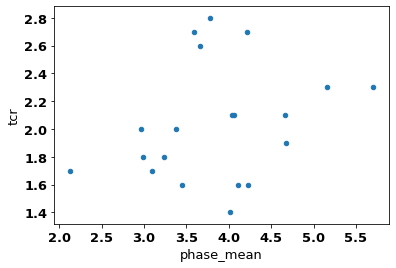

In [147]:
cmip6_stats_water_seas[cmip6_stats_water_seas['season'] == 'JJA'].plot(kind = 'scatter',
                                                                      x = 'phase_mean', 
                                                                      y = 'tcr')

In [309]:
# np.count_nonzero(~model_error_stats_df_water_cmip5_mean['ecs'].isnull())

17

In [16]:
# rr = cmip6_stats_water_summer.groupby(['season', 'model_name']).apply(df_mean_lat_weighted, field_name = 'ampl_season')

In [17]:
# df_for_stats.groupby('model_name').apply(df_mean_lat_weighted, field_name = 'ampl_season')
df_for_stats_land[['ampl_season', 'phase_season', 'model_name']].groupby('model_name').apply(lat_weighted_circ_mean, field_name = 'phase_season')
#  df_for_stats.groupby('model_name').agg(np.mean)

model_name
ACCESS-CM2          13.031600
ACCESS-ESM1-5       12.714487
AWI-CM-1-1-MR       12.672608
AWI-ESM-1-1-LR      12.918592
BCC-CSM2-MR         10.662535
CMCC-CM2-SR5        15.001520
CNRM-CM6-1          10.878504
CNRM-ESM2-1         10.615201
CanESM5             12.695258
EC-Earth3           15.130572
EC-Earth3-Veg       15.086934
EC-Earth3-Veg-LR    15.368019
FGOALS-g3            1.515634
GFDL-CM4            10.607150
GISS-E2-1-G         13.546656
IPSL-CM6A-LR        15.084323
KACE-1-0-G          12.470800
MIROC-ES2L          13.232054
MIROC6              13.969253
MPI-ESM-1-2-HAM     13.172214
MPI-ESM1-2-HR       12.677922
MPI-ESM1-2-LR       12.897989
MRI-ESM2-0          14.400313
NESM3               12.601847
SAM0-UNICON         16.028843
UKESM1-0-LL         12.332454
dtype: float64

In [246]:
# df_for_stats_land[['phase_season', 'model_name']].groupby('model_name').apply(phase_circmean)



In [243]:
# df_mean_lat_weighted(df_for_stats[df_for_stats['model_name'] == 'IPSL-CM6A-LR'], 'ampl_season')
df_test = df_for_stats_land[df_for_stats_land['model_name'] == 'ACCESS-CM2']
lat_weighted_circ_mean(df_test, field_name = 'phase_season')

13.094007048160753

In [210]:
df_mean_lat_weighted(df_for_stats_land[df_for_stats_land['model_name'] == 'ACCESS-CM2'],'phase_season' )

12.418879341498402

In [211]:
phase_circmean(df_test['phase_season'].values)

12.747074961818495

In [222]:
rr = lat_weighted_circ_mean_test(df_test, field_name = 'phase_season')

In [176]:
# cmip6_stats_water_summer
# agg_field_by_model_ = cmip6_stats_water_summer.groupby(['season','model_name']).apply(df_mean_lat_weighted, field_name = 'ampl_season')
# agg_phase_by_model_ = cmip6_stats_water_summer.groupby(['season','model_name']).apply(lat_weighted_circ_mean, field_name = 'phase_season')

In [175]:
ff = agg_phase_by_model_.reset_index('season')
ff[ff['season'] == 'SON']

season          0
model_name                        
ACCESS-CM2          SON -11.266178
ACCESS-ESM1-5       SON -11.887728
AWI-CM-1-1-MR       SON -11.581094
AWI-ESM-1-1-LR      SON -11.316528
BCC-CSM2-MR         SON  10.535746
CMCC-CM2-SR5        SON  -8.947131
CNRM-CM6-1          SON  11.095685
CNRM-ESM2-1         SON  10.853294
CanESM5             SON -11.329597
EC-Earth3           SON  -9.404818
EC-Earth3-Veg       SON  -9.391384
EC-Earth3-Veg-LR    SON  -8.920507
FGOALS-g3           SON   2.020449
GFDL-CM4            SON  10.839053
GISS-E2-1-G         SON -11.510878
IPSL-CM6A-LR        SON  -8.842505
KACE-1-0-G          SON  11.995479
MIROC-ES2L          SON -10.692395
MIROC6              SON  -9.644139
MPI-ESM-1-2-HAM     SON -10.864681
MPI-ESM1-2-HR       SON -11.618149
MPI-ESM1-2-LR       SON -11.339888
MRI-ESM2-0          SON -10.042968
NESM3               SON -11.754175
SAM0-UNICON         SON  -7.912995
UKESM1-0-LL         SON -11.843640

In [241]:
%run model_by_model_analysis_helper.py


In [100]:
ff = agg_phase_by_model_.reset_index('season')
ff[ff['season'] == 'SON']

season          0
model_name                        
ACCESS-CM2          SON -11.266178
ACCESS-ESM1-5       SON -11.887728
AWI-CM-1-1-MR       SON -11.581094
AWI-ESM-1-1-LR      SON -11.316528
BCC-CSM2-MR         SON  10.535746
CMCC-CM2-SR5        SON  -8.947131
CNRM-CM6-1          SON  11.095685
CNRM-ESM2-1         SON  10.853294
CanESM5             SON -11.329597
EC-Earth3           SON  -9.404818
EC-Earth3-Veg       SON  -9.391384
EC-Earth3-Veg-LR    SON  -8.920507
FGOALS-g3           SON   2.020449
GFDL-CM4            SON  10.839053
GISS-E2-1-G         SON -11.510878
IPSL-CM6A-LR        SON  -8.842505
KACE-1-0-G          SON  11.995479
MIROC-ES2L          SON -10.692395
MIROC6              SON  -9.644139
MPI-ESM-1-2-HAM     SON -10.864681
MPI-ESM1-2-HR       SON -11.618149
MPI-ESM1-2-LR       SON -11.339888
MRI-ESM2-0          SON -10.042968
NESM3               SON -11.754175
SAM0-UNICON         SON  -7.912995
UKESM1-0-LL         SON -11.843640

In [75]:
test_df = cmip6_stats_water_summer[(cmip6_stats_water_summer['model_name'] == 'NESM3') & \
                                  (cmip6_stats_water_summer['season'] == 'SON')]

In [76]:
print(df_mean_lat_weighted(test_df, field_name = 'ampl_season'))
print(lat_weighted_circ_mean(test_df, field_name = 'phase_season'))

1.3891463538531525
-11.754175275682945


In [141]:
print(phase_circmean(test_df['phase_season'].values))
print(test_df['phase_season'].values.mean())

11.967977757494063
11.776677370504396


In [490]:
# cmip6_stats_water_summer
mode(cmip6_stats_land['phase_mean'].values)


ModeResult(mode=array([12.8]), count=array([2]))

In [491]:
mode(cmip5_stats_land['phase_mean'].values)

ModeResult(mode=array([11.6]), count=array([2]))

In [492]:
mode(df_gpm_land['phase_season'].round(1).values)

ModeResult(mode=array([19.2]), count=array([828]))

In [123]:
# save_fig_corr_heatmap_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/corr_heatmaps/CMIP6/'
save_fig_corr_heatmap_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/tapio_update_9_10/' 

In [86]:
# cmip6_stats_water_summer

## Make Correlation Heatmap

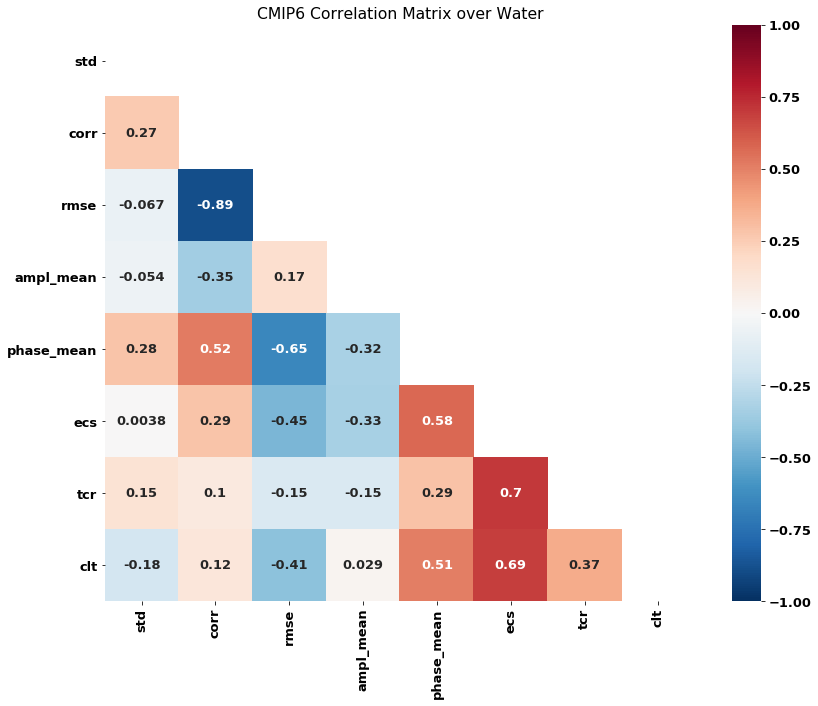

In [15]:
%run model_by_model_analysis_helper.py
# corr_mat_ds = cmip6_stats_water_summer[cmip6_stats_water_summer['season'] == 'JJA']
corr_mat_ds = model_error_stats_df_water_mean
# corr_mat_ds = model_error_stats_df_water_cmip5_mean

# corr_mat_ds = model_error_stats_df_water
# corr_mat_ds = model_error_stats_df_water_cmip5

# corr_mat_ds = cmip5_stats_water_summer
# corr_mat_ds = model_error_stats_df_water_cmip5_mean[model_error_stats_df_water_cmip5_mean['season'] == 'JJA']

plot_corr_matrix(corr_mat_ds, 
                 title = 'CMIP6 Correlation Matrix over Water')

# .drop('')
# plt.savefig(save_fig_dir_update + 'cmip6_corr_mat_water_precip_lt0pt5.png', dpi = 300)
# plt.savefig(save_fig_corr_heatmap_dir + 'cmip6_corr_mat_water_max_cloud_cover.png', dpi = 300)
# plt.savefig(save_fig_corr_heatmap_dir + 'cmip6_corr_mat_water_nh_all_djf.png', dpi = 300)

In [224]:
# model_error_stats_df #.reset_index('season')

corr_mat_ds = all_stats_df
# .drop(['IPSL-CM6A-LR']) #.drop(['BCC-CSM2-MR']) #.drop(['GFDL-ESM2M', 'MIROC5'])

# mes_df_season = model_error_stats_df.reset_index('season')
# mes_df_season = mes_df_season[mes_df_season['season'] == 'JJA']

# corr_mat_ds = mes_df_season

# plt.figure(figsize = (12,10))
# plt.title('Correlation Matrix for All Latitudes [Method: mode]')
# upper_tr_mask = np.triu(corr_mat_ds.corr())
# sns.heatmap(corr_mat_ds.corr(), annot = True, 
#             vmin = -1, vmax = 1, center = 0, fmt='.2g',
#             mask = upper_tr_mask)

# plt.tight_layout()
plot_corr_matrix(corr_mat_ds)
# plt.savefig(save_figs_dir + 'corr_heatmaps/CMIP6/' + 'land_and_water_poleward_of_35.png', dpi = 300)

NameError: name 'all_stats_df' is not defined

In [94]:
# model_error_stats_df
# model_error_stats_df.sort_values('rmse')

In [82]:
# df_cmip5_seasonal

In [36]:
def metric_scatter(df, 
                   x_field = 'phase_mean', 
                   y_field = 'ecs',
                   xlabel = 'Phase Mean [Hours]',
                   ylabel = 'ECS',
                   obs_x = None,
                   num_labels = True, 
                   new_fig = True, 
                   figsize = (8,5),
                   markerstyle = 'o', 
                   legend = True, 
                   annotate_bool = True):
#     if not (fig is None):
    if new_fig:
        plt.figure(figsize = figsize)
    # for mod_ii in model_error_stats_df.iterrows():
    model_list = list(df.index)
    for ii in range(len(df)):
        mod_ii = df.iloc[ii,:]
        xx,yy = mod_ii[x_field], mod_ii[y_field]
        if (not np.isnan(xx)) & (not np.isnan(yy)):
            plt.plot(xx, yy, markerstyle, label = str(ii) + ': ' + model_list[ii])
            if num_labels:
                plt.annotate(str(ii), (xx, yy), size = 9, weight = 'bold')
    plt.grid()
    if legend:
        plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5),prop={'size': 8})
    if xlabel:
        plt.xlabel(xlabel, weight = 'bold')
        
    if ylabel:
        plt.ylabel(ylabel, weight = 'bold')
    
    corr = df.corr()[x_field][y_field]
    print(corr)
    if annotate_bool:
        plt.annotate('Corr:' + '{:.3f}'.format(corr), 
                     xy=(0.75, 0.01), xycoords='axes fraction')
    if not (obs_x is None):
        plt.axvline(x=obs_x, color='r', linestyle='--')


    plt.tight_layout()


In [37]:

# metric_scatter(model_error_stats_df_land)
# plt.title('CMIP6 ECS vs. Diurnal Phase Land', weight = 'bold')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_land.png', dpi = 300)


metric_scatter(all_stats_df)
plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_water_25n_25_s.png', dpi = 300)

# metric_scatter(model_error_stats_df_land, y_field = 'tcr')
# plt.title('CMIP6 TCR vs. Diurnal Phase Land', weight = 'bold')
# plt.ylabel('TCR')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'tcr_vs_phase_land.png', dpi = 300)


# metric_scatter(model_error_stats_df_water, y_field = 'tcr')
# plt.title('CMIP6 TCR vs. Diurnal Phase Water', weight = 'bold')
# plt.ylabel('TCR')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'tcr_vs_phase_water.png',  dpi = 300)



NameError: name 'all_stats_df' is not defined

In [210]:
# cmip6_stats_water
# corr_mat_ds
phase_observed_water_mean

5.334830363871928

In [170]:
model_error_stats_df_water_mean['phase_mean'].values

array([3.96646445, 3.35908837, 3.03074332, 3.01783695, 2.43415105,
       3.26814417, 4.20947425, 4.26796253, 4.12410419, 3.41573997,
       3.42285527, 3.61027026, 2.63404082, 3.58772458, 2.73055255,
       4.59712935, 3.98832668, 3.86476805, 3.08222629, 3.23150017,
       2.98800564, 3.06875853, 3.93089964, 3.36396494, 4.85313049,
       3.78383277])

In [178]:
# import random
# random.choice()
%run model_by_model_analysis_helper.py

# Conf bounds 

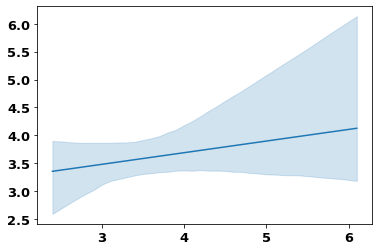

In [39]:
# one cmip iteration 
x = model_error_stats_df_water_mean['phase_mean'].values
y = model_error_stats_df_water_mean['ecs'].values

# both cmip iterations
xx_cmip5 = model_error_stats_df_water_cmip5_mean['phase_mean'].values
yy_cmip5 = model_error_stats_df_water_cmip5_mean['ecs'].values

x = np.concatenate((x,xx_cmip5))
y = np.concatenate((y, yy_cmip5))

not_nan_where = ~np.isnan(y)
x = x[not_nan_where]
y = y[not_nan_where]

XN=np.linspace(round(np.min(x),1),round(np.max(x),1)+0.1,len(x))
XN=np.expand_dims(XN,1)
XN = np.hstack((XN, np.ones((XN.shape[0], 1), dtype=XN.dtype)))
upper99,lower99,upper95,lower95,upper68,lower68,beta = regression_bounds(x,y,XN)
regression=(XN.dot(beta))
plt.plot(XN[:,0],regression,label='regression')
plt.fill_between(XN[:,0],upper95.flatten(),lower95.flatten(),color='C0',alpha = 0.2, label='99% (bootstrapped)')

In [104]:
beta

array([[0.20825   ],
       [2.85735197]])

In [98]:
df_res_cmip6 = model_error_stats_df_water_mean[['phase_mean', 'ecs']]
df_res_cmip5 = model_error_stats_df_water_cmip5_mean[['phase_mean', 'ecs']]


In [101]:
pd.concat([df_res_cmip6, df_res_cmip5], ignore_index = True).corr()

phase_mean      ecs
phase_mean     1.00000  0.16536
ecs            0.16536  1.00000

In [40]:
# upper99
# x = model_error_stats_df_water_mean['phase_mean'].values
# model_error_stats_df_water_cmip5['phase_mean']


# Scatter Plots Combined

0.575861435915524
-0.12721564746352887


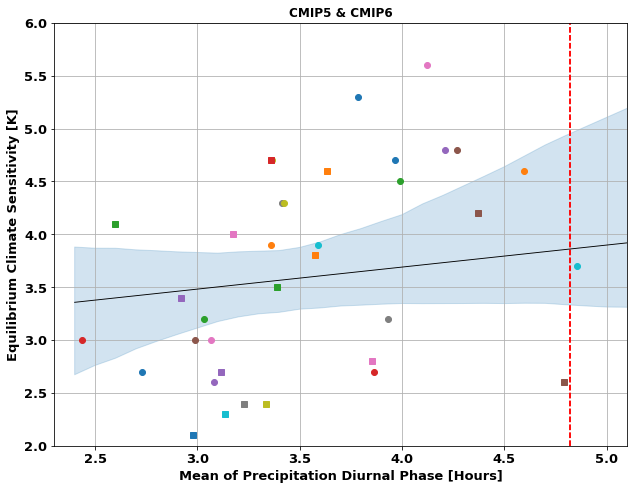

In [103]:
metric_scatter(model_error_stats_df_water_mean,  
               x_field = 'phase_mean',  
               y_field = 'ecs',
               xlabel = 'Mean of Precipitation Diurnal Phase [Hours]',
               ylabel = 'Equilibrium Climate Sensitivity [K]',
               obs_x = phase_observed_water_mean, 
               figsize = (9,7), 
               legend = False, 
               num_labels = False,
               annotate_bool=False)

metric_scatter(model_error_stats_df_water_cmip5_mean,  
               x_field = 'phase_mean',  
               y_field = 'ecs',
               xlabel = 'Mean of Precipitation Diurnal Phase [Hours]',
               ylabel = 'Equilibrium Climate Sensitivity [K]',
               new_fig = None,
               legend = False,
               markerstyle = 's',
               num_labels = None,
               obs_x = phase_observed_water_mean, 
#                figsize = (8,5), 
               annotate_bool=False)
plt.grid()
plt.plot(XN[:,0],regression,label='regression', linewidth = 0.9, c = 'k')
plt.fill_between(XN[:,0],upper95.flatten(),lower95.flatten(),color='C0',alpha = 0.2, label='99% (bootstrapped)')


plt.xlim([2.3, 5.1])
plt.ylim([2, 6.0])
plt.title('CMIP5 & CMIP6', weight = 'bold', fontsize = 12)
plt.tight_layout()
# plt.savefig(save_figs_dir_update + 'ecs_phase_cmip5_cmip6.png', dpi = 300)

# Scatter Plots

0.575861435915524
-0.12721564746352887


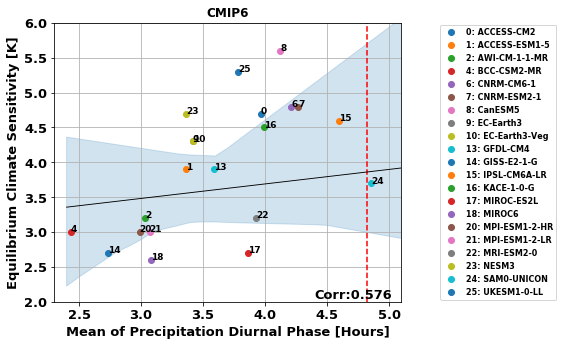

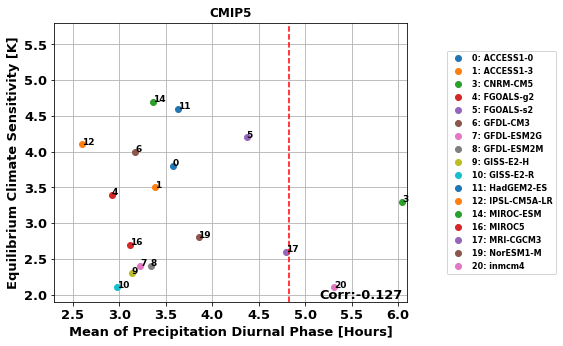

In [42]:
# plt.figure(figsize = (7,10))

metric_scatter(model_error_stats_df_water_mean,  
               x_field = 'phase_mean',  
               y_field = 'ecs',
               xlabel = 'Mean of Precipitation Diurnal Phase [Hours]',
               ylabel = 'Equilibrium Climate Sensitivity [K]',
               obs_x = phase_observed_water_mean, 
               figsize = (8,5), 
               annotate_bool=True)

plt.plot(XN[:,0],regression,label='regression', linewidth = 0.9, c = 'k')
plt.fill_between(XN[:,0],upper99.flatten(),lower99.flatten(),color='C0',alpha = 0.2, label='99% (bootstrapped)')


plt.xlim([2.3, 5.1])
plt.ylim([2, 6.0])
plt.title('CMIP6', weight = 'bold', fontsize = 12)
plt.tight_layout()

# # plt.savefig(save_figs_dir_update + 'ecs_vs_phase_water_precip_mode.png', dpi = 300)
# plt.savefig(save_figs_dir_quals + 'ecs_vs_phase_water_precip_mean_conf.png', dpi = 300)
# # plt.savefig(save_figs_dir_paper + 'ecs_vs_phase_water_cmip6.png', dpi = 300)
# # plt.savefig(save_fig_corr_heatmap_dir + 'cmip6_corr_phase_ecs_water.png', dpi = 250)

# ## CMIP6 Mode
# metric_scatter(model_error_stats_df_water,  
#                x_field = 'phase_mean',  
#                y_field = 'ecs',
#                xlabel = 'Mode of Precipitation Diurnal Phase [Hours]',
#                ylabel = 'Equilibrium Climate Sensitivity [K]',
# #                obs_x = phase_observed_water_mode, 
#                figsize = (8,5), 
#                annotate_bool=True)
# # plt.xlim([1.3, 4.3])
# # plt.ylim([2, 5.8])
# plt.title('CMIP6', weight = 'bold', fontsize = 12)
# plt.tight_layout()


# # plt.savefig(save_figs_dir_update + 'ecs_vs_phase_water_precip_mode.png', dpi = 300)
# plt.savefig(save_figs_dir_quals + 'ecs_vs_phase_water_precip_mode.png', dpi = 300)


####### CMIP5 ############
# plt.figure()

metric_scatter(model_error_stats_df_water_cmip5_mean, #.drop(['inmcm4', 'CNRM-CM5', 'MRI-CGCM3']),
               x_field = 'phase_mean',  
               y_field = 'ecs',
#                xlabel = 'Mode of Precipitation Diurnal Phase [Hours]',
               xlabel = 'Mean of Precipitation Diurnal Phase [Hours]',
               ylabel = 'Equilibrium Climate Sensitivity [K]',
               obs_x = phase_observed_water_mean, 
               figsize = (8,5), 
               annotate_bool=True)
plt.title('CMIP5', weight = 'bold', fontsize = 12)
plt.xlim([2.3, 6.1])
plt.ylim([1.9, 5.8])
plt.tight_layout()
# # plt.savefig(save_figs_dir_paper + 'ecs_vs_phase_water_cmip5.png', dpi = 300)
# plt.savefig(save_figs_dir_quals + 'ecs_vs_phase_water_precip_cmip5_mean.png', dpi = 300)


## CMIP5 mode
# metric_scatter(model_error_stats_df_water_cmip5, #.drop(['inmcm4', 'CNRM-CM5', 'MRI-CGCM3']),
#                x_field = 'phase_mean',  
#                y_field = 'ecs',
#                xlabel = 'Mode of Precipitation Diurnal Phase [Hours]',
# #                xlabel = 'Mean of Precipitation Diurnal Phase [Hours]',
#                ylabel = 'Equilibrium Climate Sensitivity [K]',
#                obs_x = phase_observed_water_mode, 
#                figsize = (8,5), 
#                annotate_bool=True)
# plt.title('CMIP5', weight = 'bold', fontsize = 12)
# plt.xlim([1, 5.5])
# plt.ylim([1.5, 5.0])
# plt.tight_layout()
# plt.savefig(save_figs_dir_quals + 'ecs_vs_phase_water_precip_cmip5_mode.png', dpi = 300)





In [261]:
# cmip6_stats_water

df_gpm_seasonal_subset = df_gpm_seasonal.reset_index(2)

df_gpm_seasonal_subset = df_gpm_seasonal_subset[df_gpm_seasonal_subset['land_sea_mask'] == 0]

df_gpm_seasonal_subset = df_gpm_seasonal_subset[df_gpm_seasonal_subset['season'] == 'JJA']


df_gpm_seasonal_subset = filter_by_lat(df_gpm_seasonal_subset, 0, 60)

In [275]:
# xr.Dataset.from_dataframe(df_gpm_seasonal_subset)['phase_season'].plot()
print(mode_apply(df_gpm_seasonal_subset['phase_season'].round(1)))
print(phase_circmean(df_gpm_seasonal_subset['phase_season']))

5.9
5.608771708489219


0.2736437152633778


Text(0.5, 1, 'CMIP6')

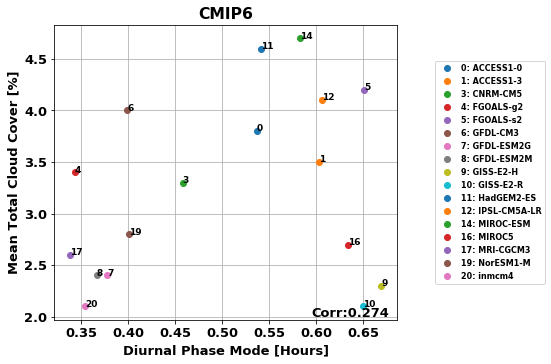

In [19]:
# sanity check modes
# mode_apply(df_cmip5[df_cmip5['model_name'] == 'GFDL-ESM2G'].round(1)['phase_season'])

metric_scatter(model_error_stats_df_water_cmip5_mean,  
               y_field = 'ecs', 
               x_field = 'ampl_mean',
               xlabel = 'Diurnal Phase Mode [Hours]',
               figsize = (8,5), 
               ylabel = 'Mean Total Cloud Cover [%]',)
plt.title('CMIP6', weight = 'bold')
# plt.savefig(save_fig_dir_update + 'clt_vs_phase_water_precip_gt_1pt5.png', dpi = 300)



In [44]:
# cmip6_stats_water


std            2.487675
corr           0.171843
rmse           4.425148
ampl_mean      0.222204
phase_mean     3.003846
ecs            3.928571
tcr            2.040000
clt           63.880296
dtype: float64

-0.1505320498942531


Text(0.5, 1, 'CMIP6 ECS vs. Diurnal Amplitude')

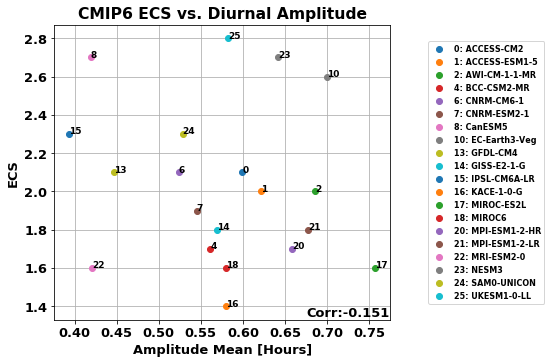

In [51]:
# (model_error_stats_df_water.drop(['MIROC-ES2L', 'MIROC6']),
metric_scatter(model_error_stats_df_water_mean, #cmip6_stats_water,  
               y_field = 'tcr', x_field = 'ampl_mean',
               xlabel = 'Amplitude Mean [Hours]')
# metric_scatter(model_error_stats_df_water_cmip5_mean, #cmip6_stats_water,  
#                y_field = 'tcr', x_field = 'ampl_mean',
#                xlabel = 'Amplitude Mean [Hours]')
plt.title('CMIP6 ECS vs. Diurnal Amplitude', weight = 'bold')

0.5418304872593092


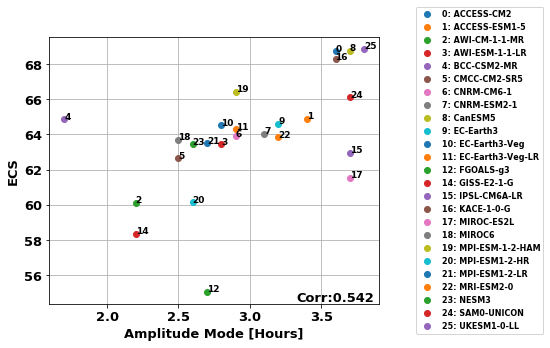

In [45]:
metric_scatter(model_error_stats_df_water,  
               y_field = 'clt', x_field = 'phase_mean',
               xlabel = 'Amplitude Mode [Hours]')
# plt.title('CMIP6 Mean Outgoing Shortwave Radiation vs. Diurnal Amplitude', weight = 'bold')
# plt.xlim([2.5, 4.5])
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP5/' + 'ecs_vs_ampl_water.png', dpi = 300)




-0.016518406073259436


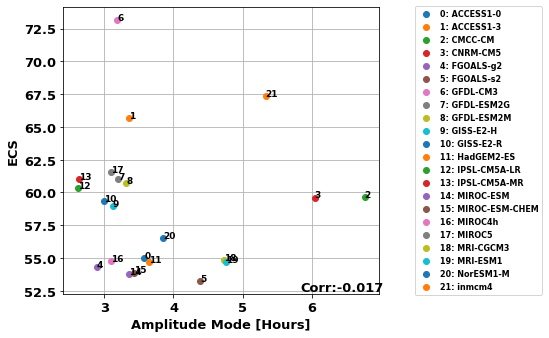

In [13]:
metric_scatter(model_error_stats_df_water_cmip5_mean,  
               y_field = 'clt', x_field = 'phase_mean',
               xlabel = 'Amplitude Mode [Hours]')

0.5418304872593092
0.5137580220471918


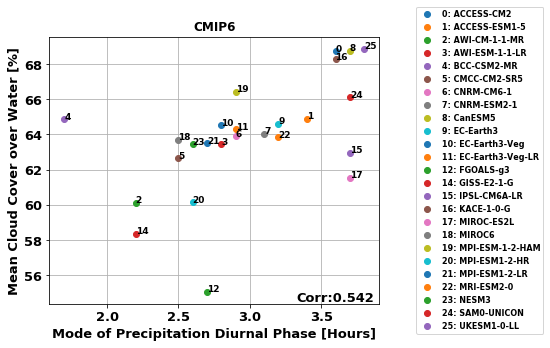

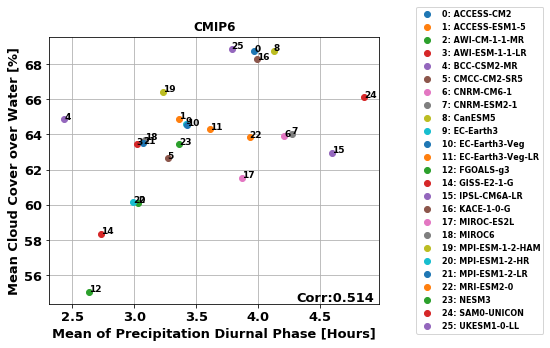

In [54]:
# metric_scatter(model_error_stats_df,  y_field = 'rlut', x_field = 'rsut')
# plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP5/' + 'ecs_vs_ampl_water.png', dpi = 300)

metric_scatter(model_error_stats_df_water,  
               y_field = 'clt', 
               x_field = 'phase_mean',
               xlabel = 'Mode of Precipitation Diurnal Phase [Hours]',
               ylabel = 'Mean Cloud Cover over Water [%]')
plt.title('CMIP6', weight = 'bold', fontsize = 12)
plt.savefig(save_figs_dir_quals + 'clt_vs_phase_water_precip_cmip6_mode.png', dpi = 300)

metric_scatter(model_error_stats_df_water_mean,  
               y_field = 'clt', 
               x_field = 'phase_mean',
               xlabel = 'Mean of Precipitation Diurnal Phase [Hours]',
               ylabel = 'Mean Cloud Cover over Water [%]')
plt.title('CMIP6', weight = 'bold', fontsize = 12)
plt.savefig(save_figs_dir_quals + 'clt_vs_phase_water_precip_cmip6_mean.png', dpi = 300)

-0.06985810196006194
-0.04807562361402879


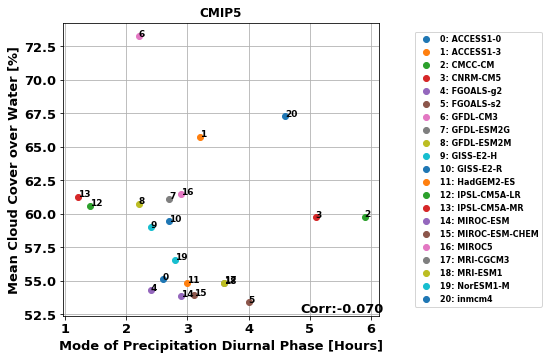

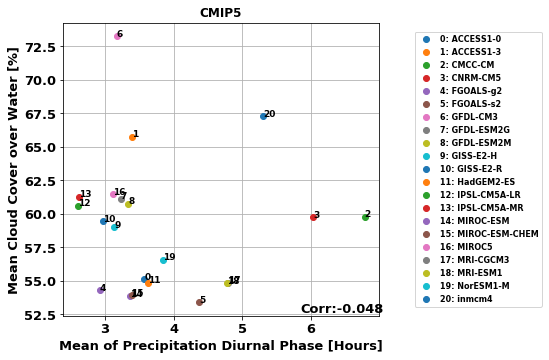

In [55]:
metric_scatter(model_error_stats_df_water_cmip5,  
               y_field = 'clt', 
               x_field = 'phase_mean',
               xlabel = 'Mode of Precipitation Diurnal Phase [Hours]',
               ylabel = 'Mean Cloud Cover over Water [%]')
plt.title('CMIP5', weight = 'bold', fontsize = 12)
plt.savefig(save_figs_dir_quals + 'clt_vs_phase_water_precip_cmip5_mode.png', dpi = 300)

metric_scatter(model_error_stats_df_water_cmip5_mean,  
               y_field = 'clt', 
               x_field = 'phase_mean',
               xlabel = 'Mean of Precipitation Diurnal Phase [Hours]',
               ylabel = 'Mean Cloud Cover over Water [%]')
plt.title('CMIP5', weight = 'bold', fontsize = 12)
plt.savefig(save_figs_dir_quals + 'clt_vs_phase_water_precip_cmip5_mean.png', dpi = 300)

-0.06985810196006194
-0.04807562361402879


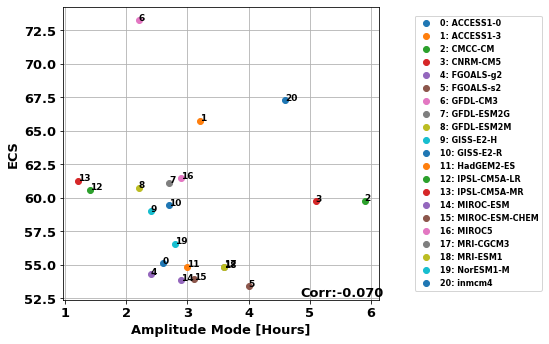

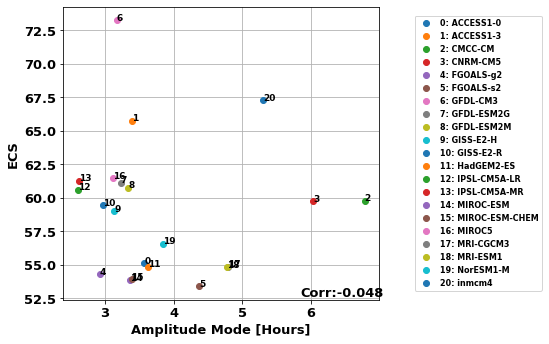

In [27]:
metric_scatter(model_error_stats_df_water_cmip5,  
               y_field = 'clt', x_field = 'phase_mean',
               xlabel = 'Amplitude Mode [Hours]')

metric_scatter(model_error_stats_df_water_cmip5_mean,  
               y_field = 'clt', x_field = 'phase_mean',
               xlabel = 'Amplitude Mode [Hours]')

In [26]:
metric_scatter(cmip6_stats_water,  
               y_field = 'cltl', 
               x_field = 'phase_mean',
               ylabel = 'Mean Total Cloud Cover [%]',
               xlabel = 'Phase',)
plt.title('CMIP6', weight = 'bold')
# plt.savefig(save_fig_corr_heatmap_dir + 'cmip6_corr_clt_ecs_water.png', dpi = 250)




# plt.savefig(save_figs_dir + 'diurnal_vs_climate/' + 'ecs_vs_tcr_cmip6.png',  dpi = 300)



NameError: name 'cmip6_stats_water' is not defined

In [38]:
# Create Taylor Diagram
# import taylorDiagram
# %%capture
%run taylorDiagram.py

In [505]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_std, 
                                          fig = fig, 
                                          label = 'GPM', 
                                          extend = False,
                                          srange=(0, 1.1)
                                          )
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats_df_water.index):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats_df_water.loc[model_name,:]['std'], 
                           corrcoef = model_error_stats_df_water.loc[model_name,:]['corr'], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
plt.title('CMIP6 vs. IMERG Precipitation Phase', weight = 'bold')
plt.tight_layout()
# plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5_water.png', dpi = 300)

NameError: name 'gpm_std' is not defined

<Figure size 936x576 with 0 Axes>

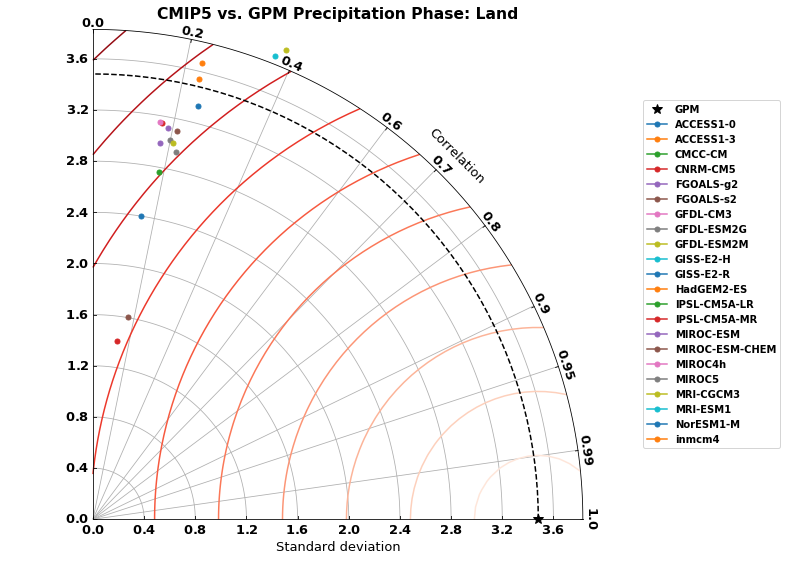

In [96]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_land_std, 
                                          fig = fig, 
                                          label = 'GPM', 
                                          extend = False,
                                          srange=(0, 1.1)
                                          )
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats_df_land.index):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats_df_land.loc[model_name,:]['std'], 
                           corrcoef = model_error_stats_df_land.loc[model_name,:]['corr'], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
plt.title('CMIP5 vs. GPM Precipitation Phase: Land', weight = 'bold')
plt.tight_layout()

# plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5_land.png', dpi = 300)

In [93]:
# mode_apply(df_for_stats_true_water['phase_season'])
# df_for_stats_true.plot(x = 'ampl_season', y = 'phase_season' , kind = 'scatter')
# sns.jointplot('ampl_season', 'phase_season', data = df_for_stats_true, 
#               kind = 'hex', xlim = [0, 0.2])
# _ = plt.hist2d(df_for_stats_true['ampl_season'], df_for_stats_true['phase_season'], bins = 300,
#               density = True, cmap = plt.get_cmap('gist_ncar'))
# plt.xlim([0, 0.2])
# plt.colorbar()

In [350]:
# df_for_stats_land
summary_stats_for_df(df_for_stats_true_land, agg_method = 'mode')

(0.4424, 19.2)

0.2944


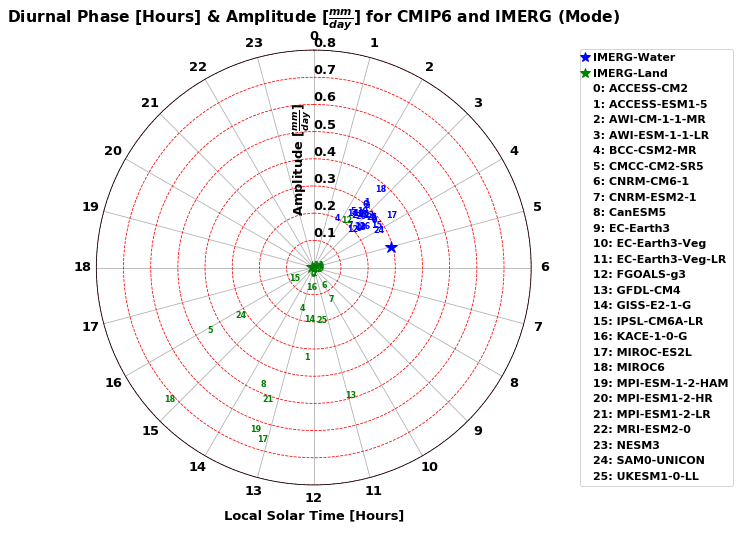

In [29]:
# import importlib
# # import PhaseDiagram
# # importlib.reload(phaseDiagram)

# # %run phaseDiagram.py
%run model_by_model_analysis_helper.py




make_phase_plot(model_error_stats_df_water,
                model_error_stats_df_land,
                df_for_stats_true_water,
                df_for_stats_true_land,
                 title = r'Diurnal Phase [Hours] & Amplitude [$\frac{mm}{day}$] for CMIP6 and IMERG (Mode)',
                agg_method = 'mode',
                y_lim = (0,0.8),
               )


plt.savefig(save_figs_dir_update + 'phase_plot_mode_cmip6.png', dpi = 300)

0.7110827131923169


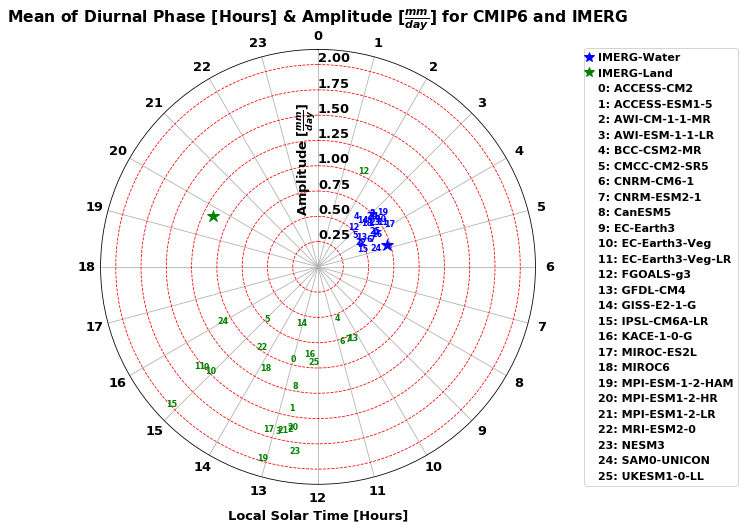

In [28]:
%run model_by_model_analysis_helper.py
make_phase_plot(model_error_stats_df_water_mean,
                model_error_stats_df_land_mean,
                df_for_stats_true_water,
                df_for_stats_true_land,
                title = r'Mean of Diurnal Phase [Hours] & Amplitude [$\frac{mm}{day}$] for CMIP6 and IMERG',
                agg_method = 'mean',
                y_lim = (0, 2.15),
               )
plt.savefig(save_figs_dir_paper + 'phase_plot_mean_cmip6.png', dpi = 300)
# plt.savefig(save_figs_dir_update + 'phase_plot_mean_cmip6.png', dpi = 300)


In [ ]:
mode_apply(df_for_stats_true_water['phase_season'].round(1))

0.2944


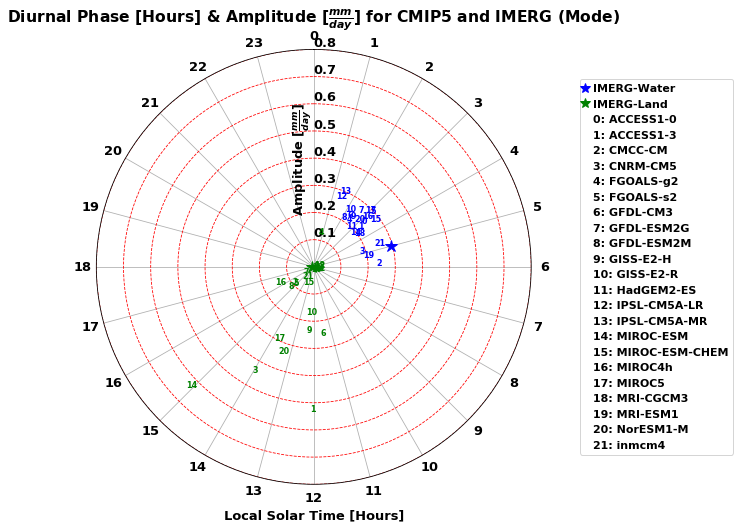

In [27]:
%run model_by_model_analysis_helper.py




make_phase_plot(model_error_stats_df_water_cmip5,
                model_error_stats_df_land_cmip5,
                df_for_stats_true_water,
                df_for_stats_true_land,
                 title = r'Diurnal Phase [Hours] & Amplitude [$\frac{mm}{day}$] for CMIP5 and IMERG (Mode)',
                agg_method = 'mode',
                y_lim = (0,0.8),
               )


plt.savefig(save_figs_dir_update + 'phase_plot_mode_cmip5.png', dpi = 300)

0.7110827131923169


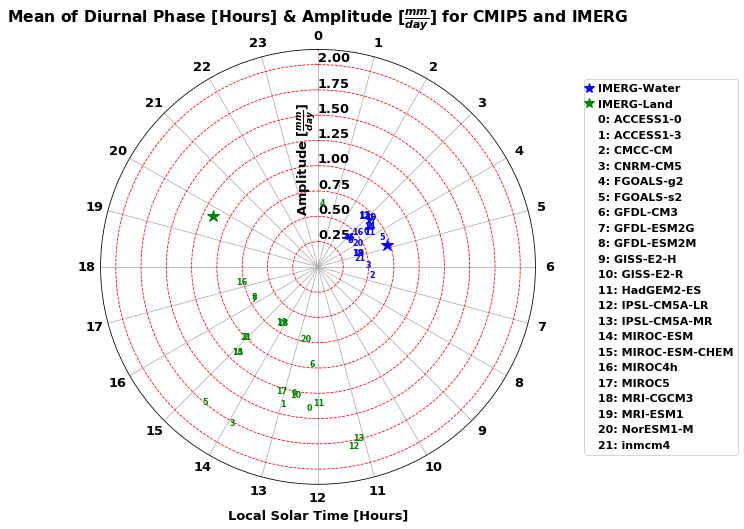

In [23]:
%run model_by_model_analysis_helper.py
make_phase_plot(model_error_stats_df_water_cmip5_mean,
                model_error_stats_df_land_cmip5_mean,
                df_for_stats_true_water,
                df_for_stats_true_land,
                title = r'Mean of Diurnal Phase [Hours] & Amplitude [$\frac{mm}{day}$] for CMIP5 and IMERG',
                agg_method = 'mean',
                y_lim = (0, 2.15),
               )
plt.savefig(save_figs_dir_paper + 'phase_plot_mean_cmip5.png', dpi = 300)
# plt.savefig(save_figs_dir_update + 'phase_plot_mean_cmip5.png', dpi = 300)





# Summary Stats for models/obs

In [18]:
%run model_by_model_analysis_helper.py

# all lats
ampl_observed_water_mean, phase_observed_water_mean = summary_stats_for_df(df_for_stats_true_water, 
                                                                 agg_method = 'mean')

# # subset lat
# ampl_observed_water_mean, phase_observed_water_mean = summary_stats_for_df(
#                                                                 filter_by_lat(df_for_stats_true_water, 
#                                                                               -60, 
#                                                                               60,
#                                                                              absolute_value = False),
#                                                                  agg_method = 'mean')

ampl_observed_land_mean, phase_observed_land_mean = summary_stats_for_df(df_for_stats_true_land, 
                                                                agg_method = 'mean')

ampl_observed_water_mode, phase_observed_water_mode = summary_stats_for_df(df_for_stats_true_water, 
                                                                 agg_method = 'mode')
    
ampl_observed_land_mode, phase_observed_land_mode = summary_stats_for_df(df_for_stats_true_land, 
                                                                agg_method = 'mode')

In [148]:
# xr.Dataset.from_dataframe(df_for_stats_true_water)['phase_season'].plot.imshow(cmap = 
#                                                                              plt.get_cmap('twilight_shifted'),vmax = 24)

In [19]:
model_error_stats_df_land_cmip5_mean['phase_mean']

ACCESS1-0         12.343417
ACCESS1-3         13.031956
CMCC-CM           14.914929
CNRM-CM5          13.932768
FGOALS-g2          0.087885
FGOALS-s2         14.686083
GFDL-CM3          12.287108
GFDL-ESM2G        16.156908
GFDL-ESM2M        16.182225
GISS-E2-H         12.780443
GISS-E2-R         12.832575
HadGEM2-ES        12.193370
IPSL-CM5A-LR      11.374360
IPSL-CM5A-MR      11.150299
MIROC-ESM         15.033379
MIROC-ESM-CHEM    14.985673
MIROC5            13.259611
MRI-CGCM3         14.327862
MRI-ESM1          14.318875
NorESM1-M         12.899651
inmcm4            15.283729
Name: phase_mean, dtype: float64

In [30]:
model_error_stats_df_land_mean['phase_mean']

ACCESS-CM2          13.031600
ACCESS-ESM1-5       12.714487
AWI-CM-1-1-MR       12.672608
AWI-ESM-1-1-LR      12.918592
BCC-CSM2-MR         10.662535
CMCC-CM2-SR5        15.001520
CNRM-CM6-1          10.878504
CNRM-ESM2-1         10.615201
CanESM5             12.695258
EC-Earth3           15.130572
EC-Earth3-Veg       15.086934
EC-Earth3-Veg-LR    15.368019
FGOALS-g3            1.515634
GFDL-CM4            10.607150
GISS-E2-1-G         13.546656
IPSL-CM6A-LR        15.084323
KACE-1-0-G          12.470800
MIROC-ES2L          13.232054
MIROC6              13.969253
MPI-ESM-1-2-HAM     13.172214
MPI-ESM1-2-HR       12.677922
MPI-ESM1-2-LR       12.897989
MRI-ESM2-0          14.400313
NESM3               12.601847
SAM0-UNICON         16.028843
UKESM1-0-LL         12.332454
Name: phase_mean, dtype: float64

In [31]:
# take mean of spatial mean for cmip5
cm5_phase_mean_water = model_error_stats_df_water_cmip5_mean.mean()['phase_mean']
cm5_phase_mean_land = phase_circmean(model_error_stats_df_land_cmip5_mean['phase_mean'])
cm5_ampl_mean_water = model_error_stats_df_water_cmip5_mean.mean()['ampl_mean']
cm5_ampl_mean_land = phase_circmean(model_error_stats_df_land_cmip5_mean['ampl_mean'])

# take mean of spatial mode for cmip5
cm5_phase_mean_water_mode = model_error_stats_df_water_cmip5.mean()['phase_mean']
cm5_phase_mean_land_mode = phase_circmean(model_error_stats_df_land_cmip5['phase_mean'])
cm5_ampl_mean_water_mode = model_error_stats_df_water_cmip5.mean()['ampl_mean']
cm5_ampl_mean_land_mode = phase_circmean(model_error_stats_df_land_cmip5['ampl_mean'])


# take mean of spatial mean for cmip6
cm6_phase_mean_water = model_error_stats_df_water_mean.mean()['phase_mean']
cm6_phase_mean_land = phase_circmean(model_error_stats_df_land_mean['phase_mean'])
cm6_ampl_mean_water = model_error_stats_df_water_mean.mean()['ampl_mean']
cm6_ampl_mean_land = model_error_stats_df_land_mean['ampl_mean'].mean()


# take mean of spatial mode for cmip6
cm6_phase_mean_water_mode = model_error_stats_df_water.mean()['phase_mean']
cm6_phase_mean_land_mode = phase_circmean(model_error_stats_df_land['phase_mean'])
cm6_ampl_mean_water_mode = model_error_stats_df_water.mean()['ampl_mean']
cm6_ampl_mean_land_mode = model_error_stats_df_land['ampl_mean'].mean()

In [32]:
print('CMIP5 Phase Stats....')
print('Water mean: ', cm5_phase_mean_water - phase_observed_water_mean)
print('Water mode: ', cm5_phase_mean_water_mode - phase_observed_water_mode)

print('Land mean: ', cm5_phase_mean_land - phase_observed_land_mean)
print('Land mode: ', cm5_phase_mean_land_mode - phase_observed_land_mode)


print('CMIP6 Phase Stats....')
print('Water mean: ', cm6_phase_mean_water - phase_observed_water_mean)
print('Water mode: ', cm6_phase_mean_water_mode - phase_observed_water_mode)

print('Land mean: ', cm6_phase_mean_land - phase_observed_land_mean)
print('Land mode: ', cm6_phase_mean_land_mode - phase_observed_land_mode)

CMIP5 Phase Stats....
Water mean:  -0.9945376455681902
Water mode:  -1.9285714285714284
Land mean:  -5.930759808080433
Land mode:  -5.058900013919828
CMIP6 Phase Stats....
Water mean:  -1.29038373905008
Water mode:  -1.9961538461538457
Land mean:  -6.538403998275642
Land mode:  -5.030857415280625


In [33]:
print('CMIP5 Ampl Stats....')
print('Water mean: ', cm5_ampl_mean_water - ampl_observed_water_mean)
# print('Water mode: ', cm5_ampl_mean_water_mode - a mpl_observed_water_mode)

print('Land mean: ', cm5_ampl_mean_land - ampl_observed_land_mean)
# print('Land mode: ', cm5_ampl_mean_land_mode - ampl_observed_land_mode)


print('CMIP6 Ampl Stats....')
print('Water mean: ', cm6_ampl_mean_water - ampl_observed_water_mean)
# print('Water mode: ', cm6_ampl_mean_water_mode - ampl_observed_water_mode)

print('Land mean: ', cm6_ampl_mean_land - ampl_observed_land_mean)
# print('Land mode: ', cm6_ampl_mean_land_mode - ampl_observed_land_mode)

CMIP5 Ampl Stats....
Water mean:  -0.20948894069770096
Land mean:  0.036821579990778064
CMIP6 Ampl Stats....
Water mean:  -0.12459014766647825
Land mean:  0.10682437786558374


In [46]:
print('CMIP5------------------')
print(model_error_stats_df_water_cmip5_mean.mean())
print(model_error_stats_df_land_cmip5_mean.mean())
print('CMIP6------------------')
print(model_error_stats_df_water_mean.mean())
print(model_error_stats_df_land_mean.mean())

CMIP5------------------
std            2.626407
corr           0.178522
rmse           4.510323
ampl_mean      0.501594
phase_mean     3.827834
ecs            3.235294
tcr            1.738889
clt           59.081528
dtype: float64
std            3.267094
corr           0.220108
rmse           6.335541
ampl_mean      1.187678
phase_mean    13.050624
ecs            3.235294
tcr            1.738889
clt           59.081528
dtype: float64
CMIP6------------------
std            2.487675
corr           0.171843
rmse           4.425148
ampl_mean      0.586493
phase_mean     3.531988
ecs            3.928571
tcr            2.040000
clt           63.880296
dtype: float64
std            3.511296
corr           0.253691
rmse           6.493573
ampl_mean      1.257584
phase_mean    12.742818
ecs            3.928571
tcr            2.040000
clt           63.880296
dtype: float64


## Spatial Mean Statistics

In [53]:
cm6_std_phase_mean_water = circstd(model_error_stats_df_water_mean['phase_mean'].values, low = 0.0, high = 24.0)
cm6_std_ampl_mean_water = model_error_stats_df_water_mean.std()['ampl_mean']
cm6_std_phase_mean_land = circstd(model_error_stats_df_land_mean['phase_mean'].values, low = 0.0, high = 24.0)
cm6_std_ampl_mean_land = model_error_stats_df_land_mean.std()['ampl_mean']



cm5_std_phase_mean_water = circstd(model_error_stats_df_water_cmip5_mean['phase_mean'].values, low = 0.0, high = 24.0)
cm5_std_ampl_mean_water = model_error_stats_df_water_cmip5_mean.std()['ampl_mean']
cm5_std_phase_mean_land = circstd(model_error_stats_df_land_cmip5_mean['phase_mean'].values, low = 0.0, high = 24.0)
cm5_std_ampl_mean_land = model_error_stats_df_land_cmip5_mean.std()['ampl_mean']


print("Summary")
print("Water")
print(cm5_std_phase_mean_water, cm5_std_ampl_mean_water)
print(cm6_std_phase_mean_water, cm6_std_ampl_mean_water)

print("Land")
print(cm5_std_phase_mean_land, cm5_std_ampl_mean_land)
print(cm6_std_phase_mean_land, cm6_std_ampl_mean_land)

Summary
Water
1.0928893952689014 0.12178620788433546
0.5917945610205627 0.11052621776429417
Land
2.242271562002216 0.3934450114032809
2.175759616609322 0.4416587632209027


In [51]:

print(model_error_stats_df_water_cmip5_mean.std())
print(model_error_stats_df_water_mean.std())

std           0.516432
corr          0.054960
rmse          0.162566
ampl_mean     0.121786
phase_mean    1.123031
ecs           0.881009
tcr           0.394281
clt           5.100634
dtype: float64
std           0.394118
corr          0.077822
rmse          0.244028
ampl_mean     0.110526
phase_mean    0.603206
ecs           0.919860
tcr           0.414729
clt           3.231309
dtype: float64


In [28]:
model_error_stats_df_water_cmip5_mean

std      corr      rmse  ampl_mean  phase_mean  ecs  tcr  \
ACCESS1-0       2.242597  0.225344  4.274346   0.536810    3.573060  3.8  1.9   
ACCESS1-3       1.785880  0.140403  4.402176   0.603283    3.387313  3.5  1.6   
CMCC-CM         3.207613  0.120743  4.699995   0.490154    6.787459  NaN  NaN   
CNRM-CM5        2.910331  0.103325  4.781426   0.457930    6.041409  3.3  2.0   
FGOALS-g2       2.550283  0.083377  4.854974   0.343069    2.922128  3.4  1.4   
FGOALS-s2       3.146557  0.203451  4.478915   0.651412    4.371015  4.2  2.4   
GFDL-CM3        2.234379  0.256432  4.336066   0.398828    3.172624  4.0  1.9   
GFDL-ESM2G      2.466285  0.246029  4.474059   0.377332    3.226530  2.4  1.1   
GFDL-ESM2M      2.552069  0.251640  4.435630   0.366409    3.336938  2.4  1.4   
GISS-E2-H       2.585333  0.176245  4.517345   0.669569    3.135635  2.3  1.7   
GISS-E2-R       2.591502  0.203104  4.519710   0.649950    2.977313  2.1  1.5   
HadGEM2-ES      2.190514  0.254042  4.243297   0.541238    3.632944  4.6  2.5   
IPSL-CM5A-LR    2.359211  0.170951  4.672867   0.606366    2.599460  4.1  2.0   
IPSL-CM5A-MR    2.300536  0.164369  4.622276   0.618494    2.624389  NaN  2.0   
MIROC-ESM       2.509454  0.143664  4.547986   0.582688    3.360942  4.7  2.2   
MIROC-ESM-CHEM  2.517546  0.154352  4.528851   0.574516    3.386838  NaN  NaN   
MIROC5          2.108480  0.108375  4.581347   0.633983    3.112757  2.7  1.4   
MRI-CGCM3       3.861351  0.178535  4.554160   0.337823    4.790896  2.6  1.6   
MRI-ESM1        3.810750  0.179366  4.535522   0.338549    4.781189  NaN  NaN   
NorESM1-M       2.675880  0.257563  4.263230   0.401190    3.852594  2.8  1.4   
inmcm4          2.548003  0.127646  4.392612   0.353876    5.311090  2.1  1.3   

                      clt  
ACCESS1-0       55.112966  
ACCESS1-3       65.748050  
CMCC-CM         59.746519  
CNRM-CM5        59.725961  
FGOALS-g2       54.271801  
FGOALS-s2       53.359686  
GFDL-CM3        73.264675  
GFDL-ESM2G      61.121880  
GFDL-ESM2M      60.725520  
GISS-E2-H       58.967584  
GISS-E2-R       59.432230  
HadGEM2-ES      54.818700  
IPSL-CM5A-LR    60.572692  
IPSL-CM5A-MR    61.265672  
MIROC-ESM       53.829214  
MIROC-ESM-CHEM  53.899843  
MIROC5          61.428473  
MRI-CGCM3       54.829807  
MRI-ESM1        54.781175  
NorESM1-M       56.537290  
inmcm4          67.272357

In [226]:
circstd(model_error_stats_df_water_cmip5_mean['phase_mean'].values, high = 24.0)

1.0745872225890156